# LISST-200x on benthic lander - data processing notebook

Disclaimer: this code is still in development and can still contain multiple errors.

The following notebook was developed by the Suspended Material and Seabed Monitoring and Modelling group (SUMO) from the Institute of Natural Sciences, Belgium. It aims at providing a standard protocol to process data collected in-situ with a LISST-200x instrument placed on a benthic lander. To use this notebook, simply import the data previously converted to csv by the LISST-200X software, run the cells containing code and inspect the results obtained. The graphs can then be saved as jpg and the processed data as csv.

In this notebook, the LISST-200x data processing has been divided into three stages:
1. *CSV data generation*: The first stage, during which the raw data is converted from .rbn to .csv, requires the use of the LISST-200X software. 
2. *Data import & flagging*: This notebook can then be used to carry out the second stage, which includes the import and pre-processing of the data (i.e. date conversion, data flagging). At the end of this stage, the user can save the full dataset with a flagging system and dates as datetime. 
3. *Statistics computation & visualization*: The third stage performs the calculation of different statistical parameters on a clean dataset (after filtrating data above a certain flag value), such as mean particle diameter, D10, D50, D90 and distribution characteristics, and displays outputs as graphs. The clean dataset as well as the graphs can be saved. 

**Important!** Before starting the processing, make sure that all the necessary packages and libraries are installed on your computer and that you run the cell below to import everything that is required. Before running this cell, make sure you've installed all the necessary packages on your computer. To do that, you can run the following line in the prompt:
- pip install tk pandas numpy matplotlib seaborn scipy

In [1]:
                                                    ## Cell 01 ##
import os
import ipywidgets as widgets
from IPython.display import display
import shutil
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter.filedialog import asksaveasfilename
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
                                                        ###

## Stage 1: Conversion of rbn files to csv files

In this stage, the conversion of the raw LISST-200x data is performed using the LISST-200X software, which can be downloaded freely on https://www.sequoiasci.com/product/lisst-200x/. Always make sure to double-check if the background is acceptable before processing the data.

## Stage 2: Data pre-processing

#### Stage 2 - Step 1 : Enter metadata

In this cell, the user will be asked to enter the campaign identification code, year at which the data were collected, the name of the sampling location and coordinates in decimal degrees (XX.XXXXX). Press enter after each input.
**Important!** Avoid using "/" in the campaign identification code, as it might create issues when saving the data.

In [2]:
                                                    ## Cell 02 ##
deployment_code = input("Enter the deployment identification code: ")
location = input("Enter the name of the sampling location: ")
latitude = input("Enter the latitude of the data: ")
longitude = input("Enter the longitude of the data: ")
                                                        ###

Enter the deployment identification code: T001
Enter the name of the sampling location: COD-T-E
Enter the latitude of the data: x
Enter the longitude of the data: y


#### Stage 2 - Step 2 : Data import & formatting

Upon running this cell, a new window should automatically open and invite the user to select the csv file to be processed. Be aware that this window might open in the background and could be hidden under the current window. Once imported, the data will be attributed column names, campaign identification number and sampling location (as inserted by the user in the cell above). In addition to that, year, day, hour, minute and second columns will be converted to jday and datetime values. A new column containing a flag value (set by default to zero at this step) will be added at the end of the dataset. 

The dataset will be displayed upon running the cell, enabling the user to check that columns and values were assigned correctly and that the calculated date and time of the data correspond to the actual sampling time.

In [16]:
                                                    ## Cell 03 ##
# Open a window to select input file
root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename(title="Select a CSV file", filetypes=[("CSV files", "*.csv")])
directory_path = os.path.dirname(file_path)

output_directory = f"{directory_path}/LISST-200x-{deployment_code}-{location}-processed"
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
    print(f'Existing output folder removed at: {output_directory}')
os.makedirs(output_directory)
print(f'Output folder created at: {output_directory}')

if file_path:  
    try:
        data = pd.read_csv(file_path, header=None, sep=",")
        print("File successfully loaded!") 
        # Add column names
        data.columns = ["1.21","1.6","1.89","2.23","2.63","3.11","3.67","4.33","5.11","6.03","7.11","8.39","9.90","11.7","13.8","16.3","19.2","22.7","26.7","31.6","37.2","43.9","51.9","61.2","72.2","85.2","101","119","140","165","195","230","273","324","386","459","laser_transmission_sensor_mW","supply_voltage_V","external_input_1_V","laser_reference_sensor_mW","depth_in_m","temperature_C","year","month","day","hour","minute","second","external_input_2_V","mean_diameter_um","total_volume_concentration_ppm","relative_humidity_%","accelerometer_x","accelerometer_y","accelerometer_z","raw_pressure_most_significant","raw_pressure_least_significant","ambient_light_counts","external_analog_input_3_V","computed_optical_transmission","beam_attenuation_m"]
        # Add deployment identification number, sampling location name, latitude and longitude
        data['deployment'] = deployment_code
        data['location'] = location
        data['latitude'] = latitude
        data['longitude'] = longitude
        for col in data.columns.difference(['deployment', 'location']):
            if pd.api.types.is_numeric_dtype(data[col]) or data[col].dtype == object:
                data[col] = data[col].astype(str).str.replace(r"[^\d.-]", "", regex=True)  # Retain numbers, decimal points, and negatives
                data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, invalid entries to NaN
        # Calculate julian day & datetime
        data['year'] = data['year'].astype(str).str.zfill(2)
        data['month'] = data['month'].astype(str).str.zfill(2)
        data['day'] = data['day'].astype(str).str.zfill(2)
        data['hour'] = data['hour'].astype(str).str.zfill(2)
        data['minute'] = data['minute'].astype(str).str.zfill(2)
        data['second'] = data['second'].astype(str).str.zfill(2)
        data['datetime'] = data['year'].astype(str) +"-"+ data['month'].astype(str) +"-"+ data['day'].astype(str)+" "+data['hour'].astype(str) +":"+ data['minute'].astype(str) +":"+ data['second'].astype(str)
        data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
        data['jday'] = data['datetime'].dt.dayofyear + \
               (data['datetime'].dt.hour / 24) + \
               (data['datetime'].dt.minute / 1440) + \
               (data['datetime'].dt.second / 86400)
        data['flag'] = 0
        # Compute sampling start and stop datetime
        sampling_start = data['datetime'].min()
        sampling_stop = data['datetime'].max()
        # Display output
        print(f'Data were collected at {location} between {sampling_start} and {sampling_stop} during deployment {deployment_code}.')
        display(data)
    except Exception as e:
        print(f"Error reading the file: {e}")
else:
    print("No file selected")
                                                        ###

Existing output folder removed at: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed
Output folder created at: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed
File successfully loaded!
Data were collected at COD-T-E between 2022-08-20 08:48:50 and 2022-10-06 18:03:50 during deployment T001.


,1.21,1.6,1.89,2.23,2.63,3.11,3.67,4.33,5.11,6.03,...,external_analog_input_3_V,computed_optical_transmission,beam_attenuation_m,deployment,location,latitude,longitude,datetime,jday,flag
0,0.0000,0.0000,0.0000,0.0000,0.0043,0.0334,0.0449,0.0771,0.2678,0.7872,...,0.139,0.676,15.681,T001,COD-T-E,NaN,NaN,2022-08-20 08:48:50,232.367245,0
1,0.0000,0.0000,0.0000,0.0000,0.0052,0.0377,0.0490,0.0802,0.2658,0.7513,...,0.139,0.678,15.544,T001,COD-T-E,NaN,NaN,2022-08-20 08:49:50,232.367940,0
2,0.0000,0.0000,0.0000,0.0000,0.0047,0.0358,0.0471,0.0777,0.2625,0.7548,...,0.139,0.676,15.659,T001,COD-T-E,NaN,NaN,2022-08-20 08:50:50,232.368634,0
3,0.0000,0.0000,0.0000,0.0000,0.0064,0.0413,0.0534,0.0896,0.2863,0.7845,...,0.139,0.666,16.238,T001,COD-T-E,NaN,NaN,2022-08-20 08:51:50,232.369329,0
4,0.0000,0.0000,0.0000,0.0000,0.0024,0.0251,0.0354,0.0634,0.2496,0.8116,...,0.139,0.669,16.086,T001,COD-T-E,NaN,NaN,2022-08-20 08:52:50,232.370023,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67694,18.1111,54.8134,118.3374,270.4695,518.0312,628.5036,439.4660,251.4607,228.8120,199.9639,...,0.139,0.002,241.247,T001,COD-T-E,NaN,NaN,2022-10-06 17:59:50,279.749884,0
67695,5.1547,15.9203,34.8349,80.7131,156.2456,190.5302,133.3306,76.5640,69.9478,61.2769,...,0.139,0.008,193.088,T001,COD-T-E,NaN,NaN,2022-10-06 18:00:50,279.750579,0
67696,10.1665,31.3830,68.7284,159.6817,310.7005,381.6344,269.0429,155.9633,143.3153,126.1241,...,0.139,0.004,220.814,T001,COD-T-E,NaN,NaN,2022-10-06 18:01:50,279.751273,0
67697,7.0102,21.8562,48.1859,112.7442,220.7518,272.5748,193.0559,112.5634,103.5285,91.0400,...,0.139,0.006,207.414,T001,COD-T-E,NaN,NaN,2022-10-06 18:02:50,279.751968,0


#### Stage 2 - Step 3: Flagging of the data

In this cell, flagging operations are performed as follows:
1. A first check is done on the **reference laser**, if values are below 0.2 mW, this indicates that the laser is likely not working properly. Quality flags will be assigned to 1 if data are above this value and to 3 if not (see flags meaning below). If more than 10% of the data present such a low value, a warning message will be displayed.  
2. Data out of the water are flagged with the value of 4 (rows where the beam attenuation is equal to zero). The **beam attenuation** corresponds to the loss of light intensity when a laser beam passes through water, due to both absorption and scattering. Higher attenuation values typically indicate more turbid water. 
3. The **laser transmission** values are checked. This indicates how much of the laser light has passed through water without being absorbed or scattered. A value of 100% indicates that there has been no light loss through the sample (either water without particles or air) while values below indicate scattering and absorption (which is expected in seawater). Values above 100%, however, indicate a sensor malfunction or miscalibration. If most data (>50%) are above 100%, then a warning message is generated. Data above 100 are flagged with the value of 3. 
4. The **optical transmission** is checked: values should be ranging between 0 and 1. Values outside that range should be discarded (flag 4). However, values above 0.98-0.995 reflect extremely clear water conditions, meaning a low signal-to-noise ratio (flag 3, to be taken with caution. Above that range, values should be discarded), whereas values below 0.10 reflect very turbid data and should be discarded. 
5. Finally, a flag of 3 is attributed to **outliers** detected based on the total volume concentration, depth, optical beam transmission and temperature and comparing the value of each point to the calculated mean over a moving window of 25 points. Values are considered outliers when they are higher or lower than the moving average plus or minus three times the standard deviation.

Once the flagging has been performed, a graph allows the user to visualize the quality of the data. The complete flagged dataset is automatically saved in the output directory selected by the user at the beginning of this notebook. In stage 3, a cell then allows to filter out all the data with a quality flag equal or higher than 4.

Quality flags are defined following the quality flags standards defined by the NERC Environmental Data Service of the British Oceanographic Data Centre (https://vocab.nerc.ac.uk/collection/L20/current/):
0: No quality control
1: Good value
2: Probably good value
3: Probably bad value
4: Bad value
5: Changed value
6: Value below detection
7: Value in excess
8: Interpolated value
9: Missing value

Number of outliers detected: 638
Flagging has been successfully performed on the complete dataset:


,1.21,1.6,1.89,2.23,2.63,3.11,3.67,4.33,5.11,6.03,...,latitude,longitude,datetime,jday,flag,is_outlier_total_volume_concentration_ppm,is_outlier_temperature_C,is_outlier_depth_in_m,is_outlier_computed_optical_transmission,is_outlier
0,0.0000,0.0000,0.0000,0.0000,0.0043,0.0334,0.0449,0.0771,0.2678,0.7872,...,NaN,NaN,2022-08-20 08:48:50,232.367245,1,False,False,False,False,False
1,0.0000,0.0000,0.0000,0.0000,0.0052,0.0377,0.0490,0.0802,0.2658,0.7513,...,NaN,NaN,2022-08-20 08:49:50,232.367940,1,False,False,False,False,False
2,0.0000,0.0000,0.0000,0.0000,0.0047,0.0358,0.0471,0.0777,0.2625,0.7548,...,NaN,NaN,2022-08-20 08:50:50,232.368634,1,False,False,False,False,False
3,0.0000,0.0000,0.0000,0.0000,0.0064,0.0413,0.0534,0.0896,0.2863,0.7845,...,NaN,NaN,2022-08-20 08:51:50,232.369329,1,False,False,False,False,False
4,0.0000,0.0000,0.0000,0.0000,0.0024,0.0251,0.0354,0.0634,0.2496,0.8116,...,NaN,NaN,2022-08-20 08:52:50,232.370023,1,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67694,18.1111,54.8134,118.3374,270.4695,518.0312,628.5036,439.4660,251.4607,228.8120,199.9639,...,NaN,NaN,2022-10-06 17:59:50,279.749884,4,False,False,False,False,False
67695,5.1547,15.9203,34.8349,80.7131,156.2456,190.5302,133.3306,76.5640,69.9478,61.2769,...,NaN,NaN,2022-10-06 18:00:50,279.750579,4,False,False,False,False,False
67696,10.1665,31.3830,68.7284,159.6817,310.7005,381.6344,269.0429,155.9633,143.3153,126.1241,...,NaN,NaN,2022-10-06 18:01:50,279.751273,4,False,False,False,False,False
67697,7.0102,21.8562,48.1859,112.7442,220.7518,272.5748,193.0559,112.5634,103.5285,91.0400,...,NaN,NaN,2022-10-06 18:02:50,279.751968,4,False,False,False,False,False


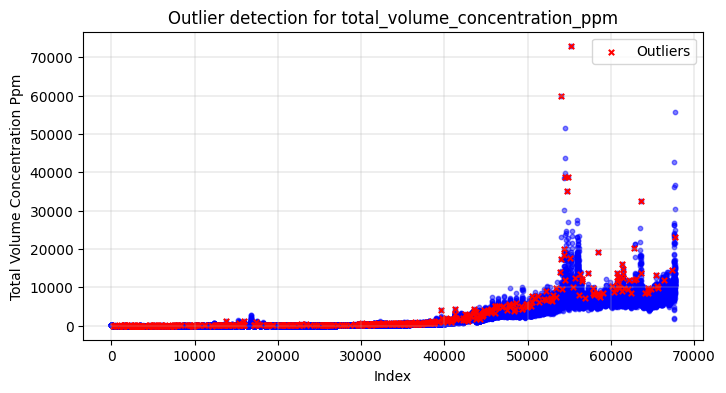

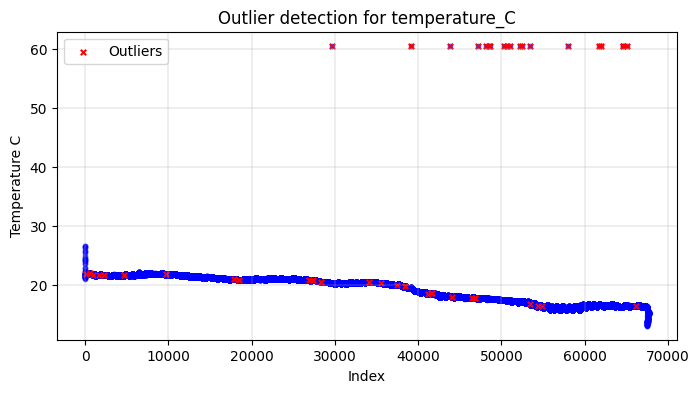

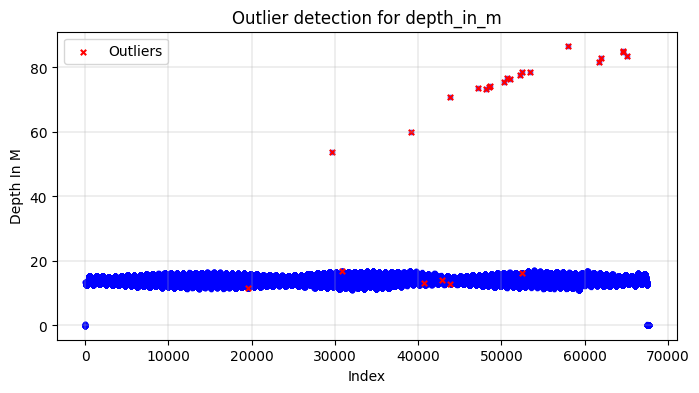

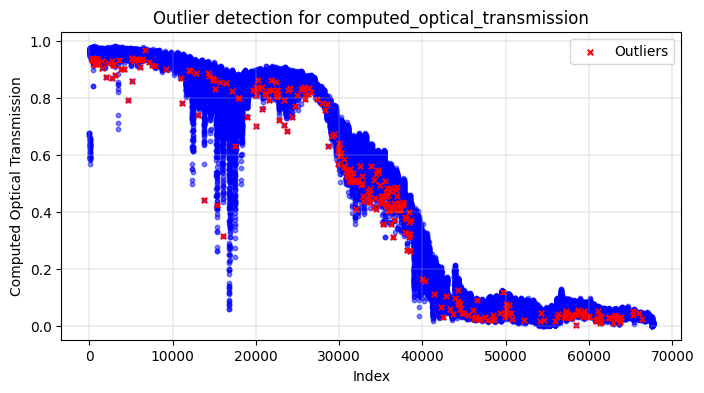

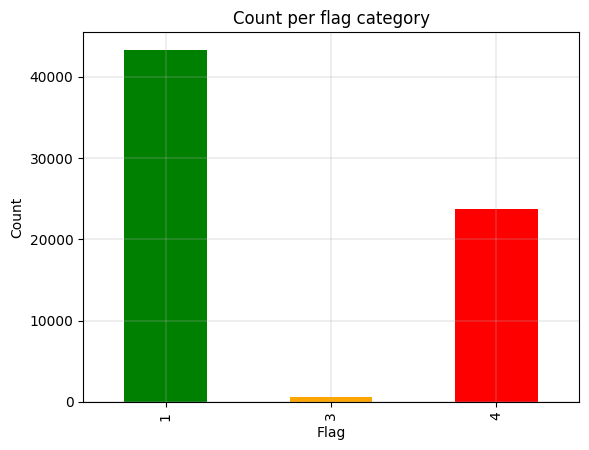

File saved to C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/Tripod_COD_T001_LISST200x_processed_rs.csv


In [17]:
                                                    ## Cell 04 ##
# Step 1: Flagging based on reference_laser
data['flag'] = data.apply(lambda row: max(row['flag'], 1) if row['laser_reference_sensor_mW'] > 0.02 else max(row['flag'], 3), axis=1)
reference_below_thsld = (data['laser_reference_sensor_mW'] <= 0.02).sum() / len(data) * 100
if reference_below_thsld > 20:  # If more than 20% of the data are below 0.02 mW
    messagebox.showwarning("Laser should be checked", 
                           f"Warning: {reference_below_thsld:.0f}% of the data have a laser reference value below 0.02 mW. "
                           "Please check laser.")

# Step 2: Beam attenuation flagging
data['flag'] = data.apply(lambda row: max(row['flag'], 4) if row['beam_attenuation_m'] <= 0 else row['flag'], axis=1)

# Step 3: Laser transmission flagging
data['flag'] = data.apply(lambda row: 3 if row['laser_transmission_sensor_mW'] > 100 and row['flag'] < 3 else row['flag'], axis=1)
underwater_data = data[data['beam_attenuation_m'] > 0]
above_100_percent = (underwater_data['laser_transmission_sensor_mW'] > 100).sum() / len(underwater_data) * 100
above_100_percent = (data['laser_transmission_sensor_mW'] > 100).sum() / len(data) * 100
if above_100_percent > 50:  # If more than 50% of the data are above 100%
    messagebox.showwarning("Recalibration Needed", 
                           f"Warning: {above_100_percent:.0f}% of the underwater data are above 100% transmission. "
                           "Please recalibrate the sensor.")
    
# Step 4: Optical transmission flagging
data['flag'] = data.apply(lambda row: 3 if row['computed_optical_transmission'] > 0.98 and row['computed_optical_transmission'] < 0.995 and row['flag'] < 3 else row['flag'], axis=1)
data['flag'] = data.apply(lambda row: 4 if row['computed_optical_transmission'] >= 0.995 and row['flag'] < 4 else row['flag'], axis=1)
data['flag'] = data.apply(lambda row: 4 if row['computed_optical_transmission'] <= 0.10 and row['flag'] < 4 else row['flag'], axis=1)
    
# Step 5: Outlier detection using rolling mean and standard deviation
columns_to_check = ['total_volume_concentration_ppm', 'temperature_C', 'depth_in_m', 'computed_optical_transmission']
window_size = 25  # Define the window size for rolling calculations
threshold = 3  # Define the threshold for outlier detection

for col in columns_to_check:
    rolling_mean = data[col].rolling(window=window_size, center=True).mean()
    rolling_std = data[col].rolling(window=window_size, center=True).std()
    outlier_column = f'is_outlier_{col}'  # Create a column to flag outliers for each variable
    data[outlier_column] = abs(data[col] - rolling_mean) > (threshold * rolling_std)

    # Update the 'flag' column if the data is an outlier
    data['flag'] = data.apply(
        lambda row: 3 if row[outlier_column] else row['flag'], axis=1
    )

# Combine all outlier flags into one column for visualization
data['is_outlier'] = data[[f'is_outlier_{col}' for col in columns_to_check]].any(axis=1)

# Count total outliers
outlier_count = data['is_outlier'].sum()
print(f'Number of outliers detected: {outlier_count}')

# Warning message if quality flags exceed 75%
percentage_high_flags = (data['flag'] >= 3).sum() / len(data) * 100
if percentage_high_flags > 75:  # If more than 75% of the data have a quality flag of 3 or higher
    messagebox.showwarning("Unsatisfactory data quality", 
                           f"Warning: {percentage_high_flags:.0f}% of the data have a quality flag above 3. "
                           "Data should be used with caution.")

# Output
print('Flagging has been successfully performed on the complete dataset:')
display(data)

# Visualizing outliers for each column
for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    plt.scatter(data.index, data[col], label='', color='blue', s=10, alpha=0.5)
    plt.scatter(
        data[data[f'is_outlier_{col}']].index, 
        data[data[f'is_outlier_{col}']][col], 
        label='Outliers', color='red', marker='x', s=15
    )
    plt.grid(axis='both', which='both', linewidth=0.3)
    plt.title(f'Outlier detection for {col}')
    plt.xlabel('Index')
    plt.ylabel(col.replace('_', ' ').title())
    plt.legend()
    plt.show()

# Visualizing flags
flag_counts = data['flag'].value_counts().sort_index()
colors = {1: 'green', 2: 'yellow', 3: 'orange', 4: 'red'}
fig, ax = plt.subplots()
flag_counts.plot(kind='bar', color=[colors.get(flag, 'blue') for flag in flag_counts.index], ax=ax)
ax.grid(axis='both', which='both', linewidth=0.3)
ax.set_title("Count per flag category")
ax.set_xlabel("Flag")
ax.set_ylabel("Count")
plt.show()

# Save as csv
data_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-full-data.csv"
if data_path:
    data.to_csv(data_path, index=False)
    print(f"File saved to {file_path}")
else:
    print("Save operation cancelled.")
                                                        ###

## Stage 3: Statistics computation & visualization

#### Stage 3 - Step 1: Statistics computation

By running this cell, a series of statistics are calculated on the full dataset. This includes:
1. **Total volume concentration**: This sums up the volume concentration of each grain size class per row.
2. **Relative volume concentration**: This calculates the percentage that each class represents compared to the total volume concentration.
3. **Mean diameter**: This corresponds to the mean diameter of particles in each row weighted by their volume concentration and normalized by the total volume concentration.
4. **D10, D50, D90 values**: These represent the diameter below which 10%, 50% or 90% of the volume of the data are found. The D10 helps characterizing the finer fraction of the sample, the D50 corresponds to the median diameter and the D90 characterizes the coarser sediment fraction. These values are calculated based on the cumulative distribution.
5. **Span**: It is a measure of the sorting of particle sizes, as a normalized measure of the distribution spread around the median particle size, showing the relative range of the middle 80% of the particle size distribution. Small values indicate good sorting (close to 1) while a larger span indicates poor sorting of the particles.
6. **Standard deviation**: It measures the average dispersion of particle sizes from the mean, a greater standard deviation shows greater variability around the mean with possible outliers or tails. If the span and standard deviation are low, it shows a uniform distribution; if the span is moderate but the standard deviation is high, it shows a moderate spread with outliers; and if the span and standard deviation are high, it shows a wide distribution.
7. **Mode**: The mode is the particle size that has the largest volume of the distribution (peak in the distribution).
8. **Peaks in the distribution**: It identifies peaks in the particle size distribution.

The particle size distribution combined with the cumulative volume concentration is displayed upon running of this cell as well as a table with the mean value of all the calculated parameters. The graph and updated complete clean dataframe are automatically saved in the directory selected by the user.

Statistics have been successfully computed


,1.21,1.6,1.89,2.23,2.63,3.11,3.67,4.33,5.11,6.03,...,324_%,386_%,459_%,D10_um,D50_um,D90_um,span,std_dev_um,mode_um,peaks
0,0.0000,0.0000,0.0000,0.0000,0.0043,0.0334,0.0449,0.0771,0.2678,0.7872,...,1.564192,16.692273,69.092783,51.9,459.0,459.0,0.886928,165.126657,459.0,"[7.11, 11.7, 16.3, 22.7, 51.9]"
1,0.0000,0.0000,0.0000,0.0000,0.0052,0.0377,0.0490,0.0802,0.2658,0.7513,...,1.381410,15.875648,70.594073,61.2,459.0,459.0,0.866667,162.699256,459.0,"[7.11, 11.7, 16.3, 22.7, 51.9]"
2,0.0000,0.0000,0.0000,0.0000,0.0047,0.0358,0.0471,0.0777,0.2625,0.7548,...,1.466029,16.459976,70.017355,61.2,459.0,459.0,0.866667,162.389679,459.0,"[7.11, 11.7, 16.3, 22.7, 51.9]"
3,0.0000,0.0000,0.0000,0.0000,0.0064,0.0413,0.0534,0.0896,0.2863,0.7845,...,1.233931,14.990583,71.894334,61.2,459.0,459.0,0.866667,162.225561,459.0,"[7.11, 11.7, 16.3, 51.9]"
4,0.0000,0.0000,0.0000,0.0000,0.0024,0.0251,0.0354,0.0634,0.2496,0.8116,...,1.647836,17.779872,68.263504,61.2,459.0,459.0,0.866667,163.389818,459.0,"[7.11, 16.3, 22.7, 51.9]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67694,18.1111,54.8134,118.3374,270.4695,518.0312,628.5036,439.4660,251.4607,228.8120,199.9639,...,12.146092,14.775796,16.657713,19.2,273.0,459.0,1.610989,178.539453,459.0,"[3.11, 22.7]"
67695,5.1547,15.9203,34.8349,80.7131,156.2456,190.5302,133.3306,76.5640,69.9478,61.2769,...,12.158321,14.980025,16.911421,16.3,273.0,459.0,1.621612,179.771062,459.0,"[3.11, 26.7]"
67696,10.1665,31.3830,68.7284,159.6817,310.7005,381.6344,269.0429,155.9633,143.3153,126.1241,...,12.280325,15.004679,16.581776,16.3,273.0,459.0,1.621612,179.789480,459.0,"[3.11, 22.7]"
67697,7.0102,21.8562,48.1859,112.7442,220.7518,272.5748,193.0559,112.5634,103.5285,91.0400,...,12.349442,14.940296,16.153741,16.3,273.0,459.0,1.621612,179.070998,459.0,"[3.11, 26.7]"


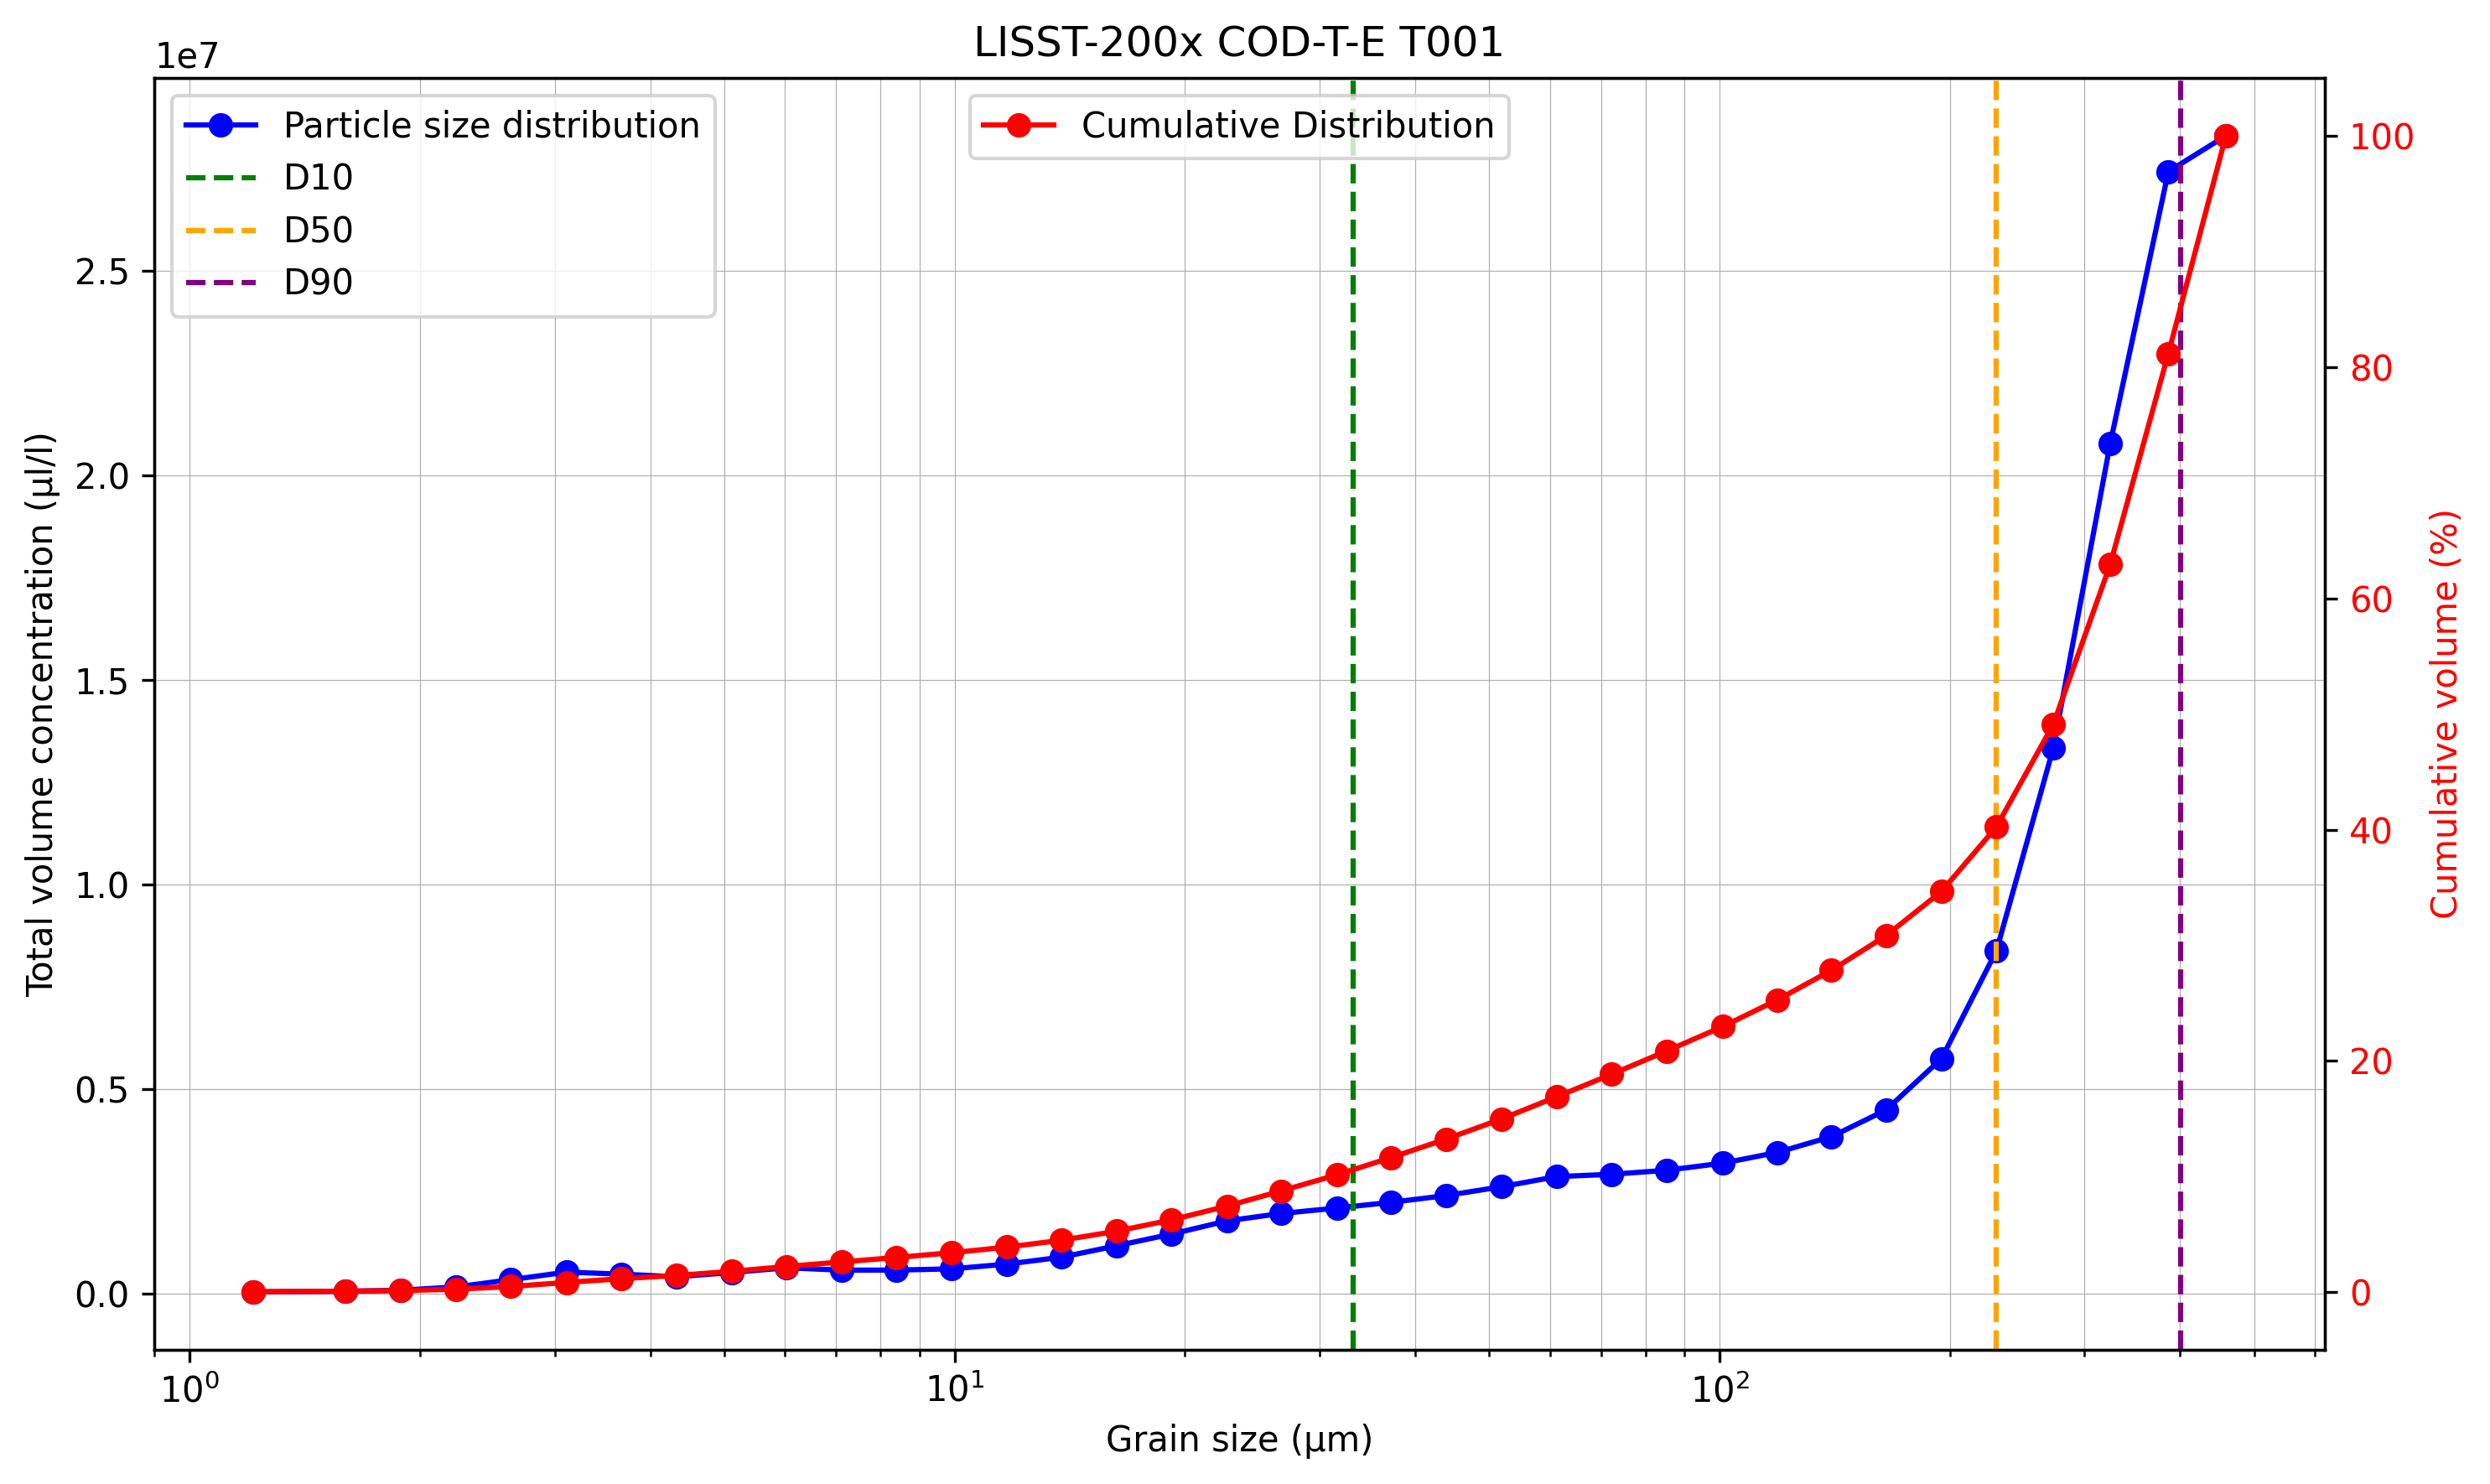

Mean values of calculated parameters for the complete clean dataset:


,Total volume concentration (ppm),Mean diameter (µm),D10 (µm),D50 (µm),D90 (µm),Span,Standard deviation (µm),Mode (µm)
0,2220.032053,153.355804,33.224951,229.85046,400.065413,1.757608,150.536468,335.884788


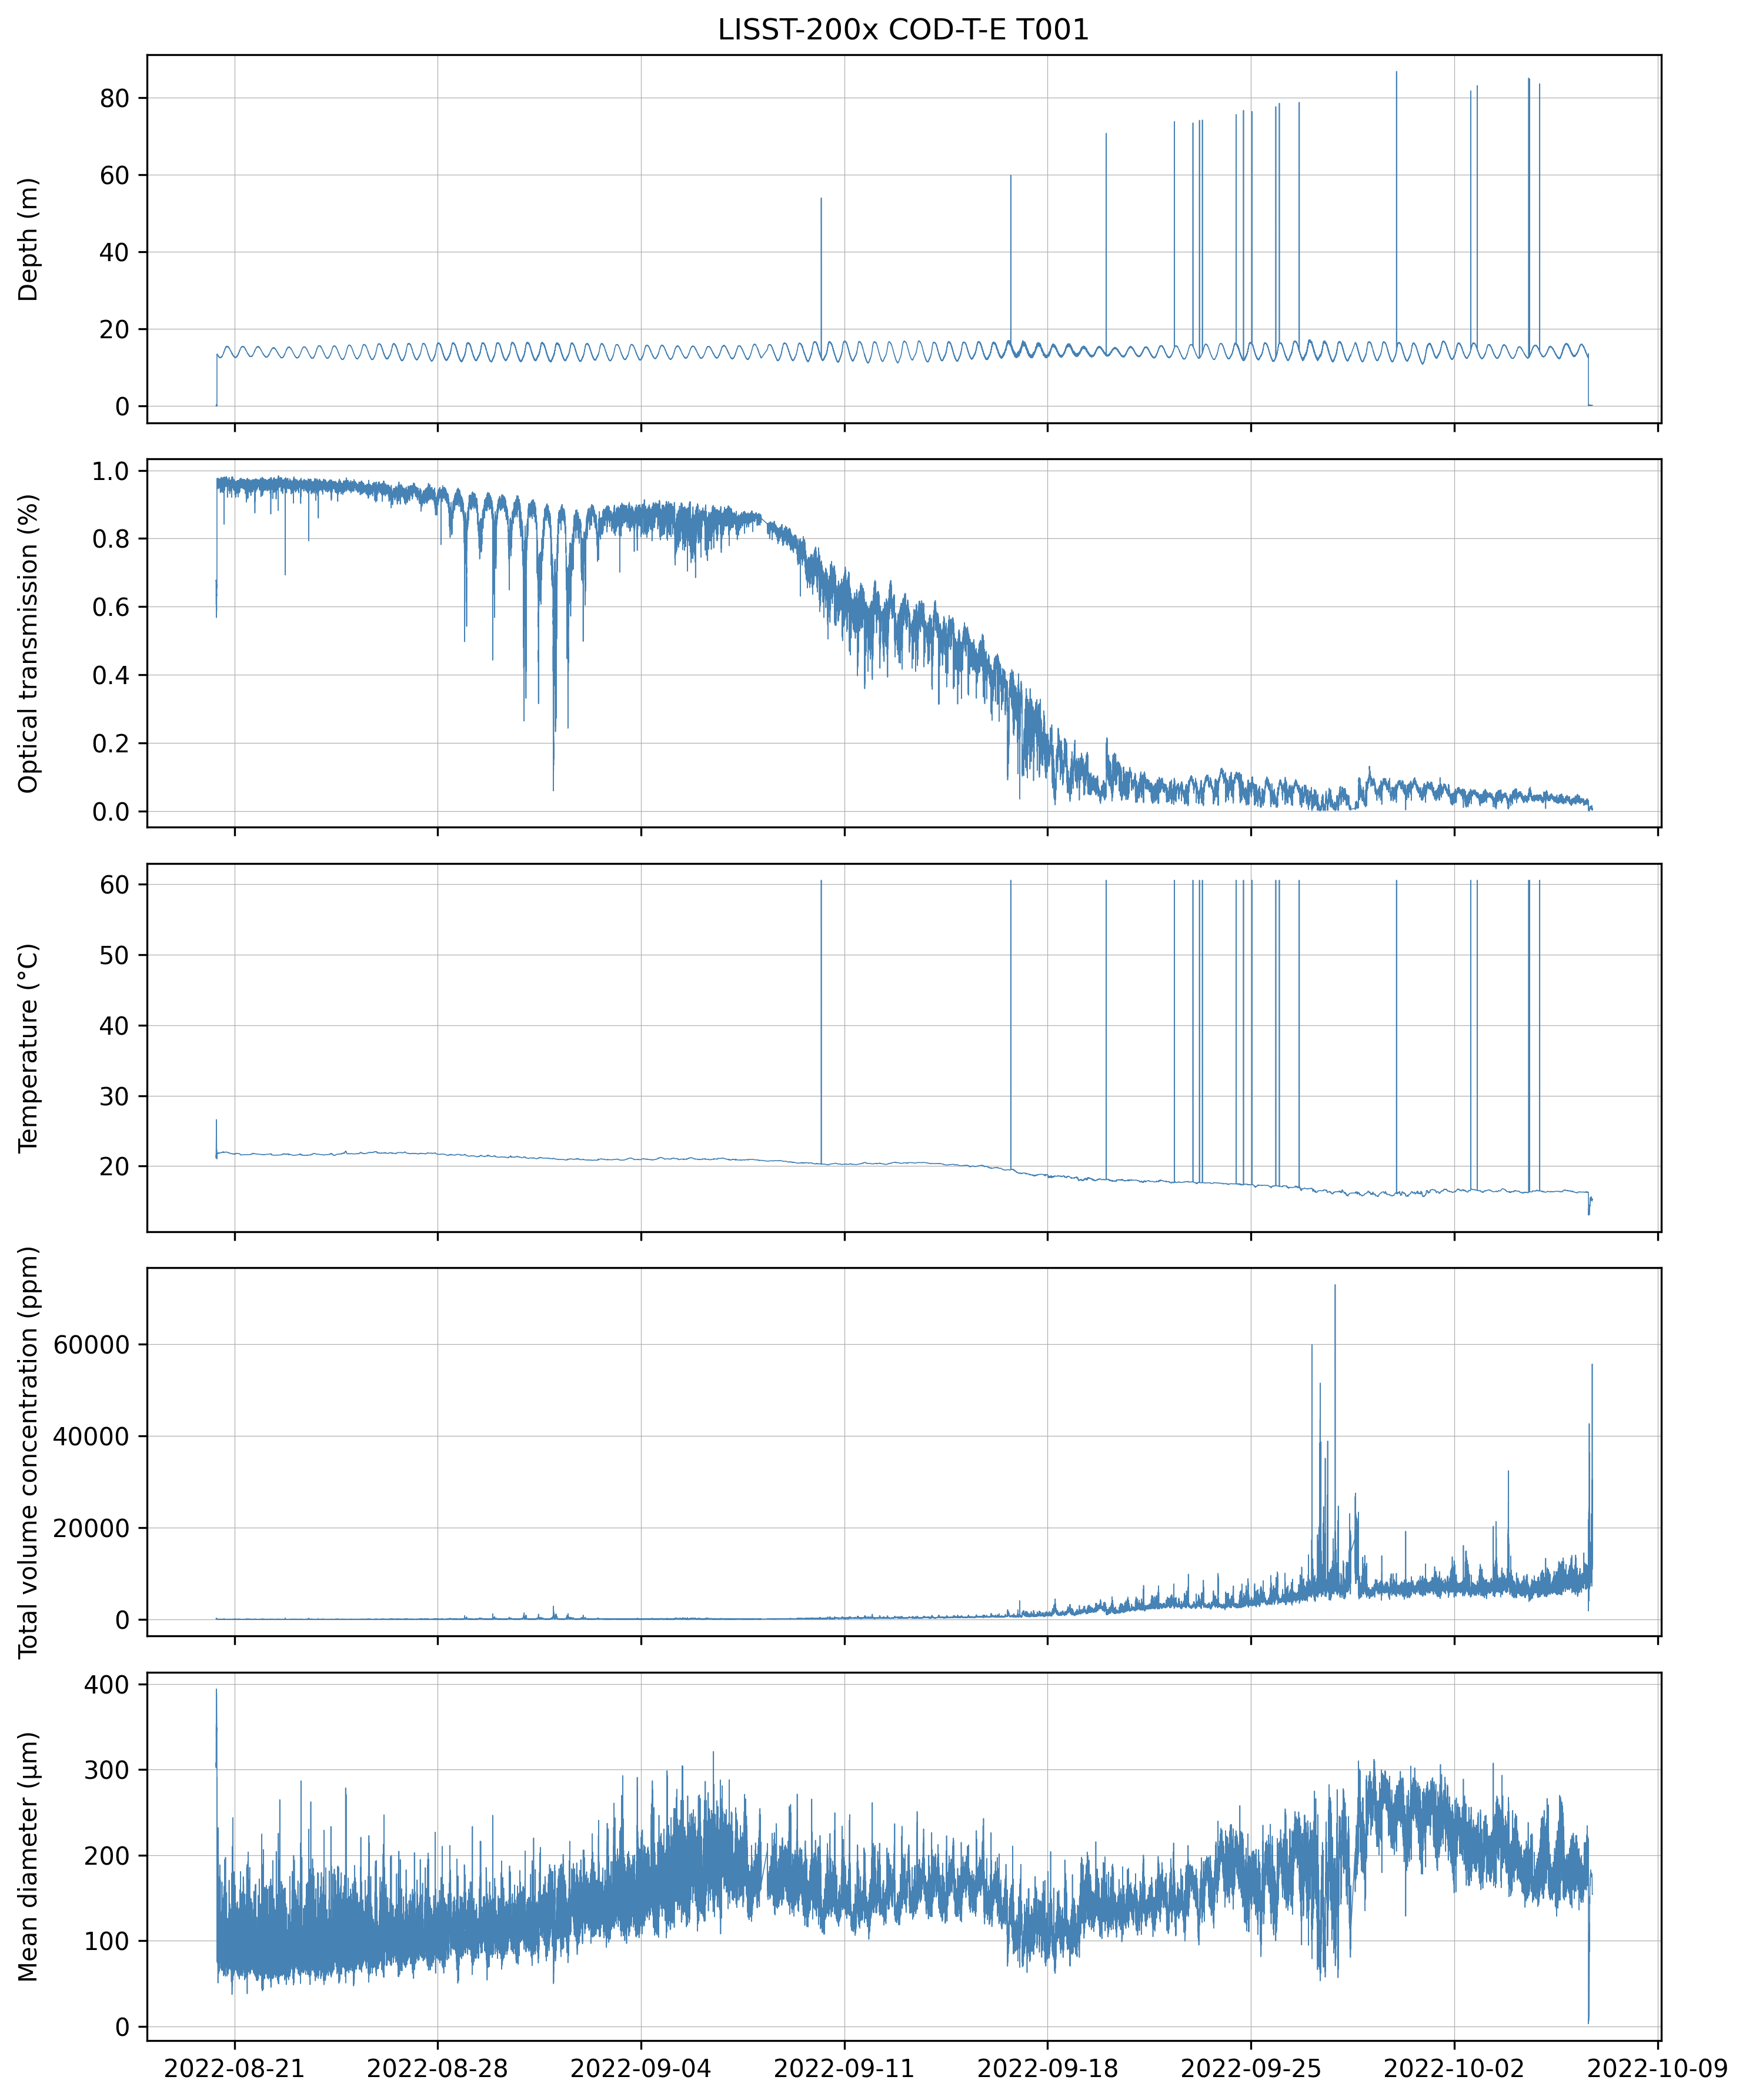

Graphs are saved to: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed


In [22]:
                                                    ## Cell 05 ##  
# Calculate the total volume concentration 
volume_concentration_columns = ["1.21","1.6","1.89","2.23","2.63","3.11","3.67","4.33","5.11","6.03","7.11","8.39","9.90","11.7","13.8","16.3","19.2","22.7","26.7","31.6","37.2","43.9","51.9","61.2","72.2","85.2","101","119","140","165","195","230","273","324","386","459"]
average_volume_fractions = data[volume_concentration_columns].mean()
volume_concentrations = data[volume_concentration_columns].values
grain_sizes = np.array([float(col) for col in volume_concentration_columns])

# Calculate the percentage of each class compared to the total volume concentration
for col in volume_concentration_columns:
    data[f'{col}_%'] = ((data[col] / data['total_volume_concentration_ppm']) * 100).astype(float)

# Cumulative volume concentration
cumulative_volumes = np.cumsum(data[volume_concentration_columns].values, axis=1)

# Percentiles calculation function
def calculate_d_percentile(cumulative_volumes, grain_sizes, total_volume, percentile):
    target = total_volume * (percentile / 100.0)
    d_percentile = []
    for i in range(len(total_volume)):
        if total_volume.iloc[i] == 0: 
            d_percentile.append(np.nan)
        else:
            greater_equal_idx = np.argmax(cumulative_volumes[i, :] >= target.iloc[i])
            d_percentile.append(grain_sizes[greater_equal_idx])
    return np.array(d_percentile)

# Calculate D10, D50, D90
data['D10_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ppm'], 10)
data['D50_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ppm'], 50)
data['D90_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ppm'], 90)

# Calculate the span
data['span'] = (data['D90_um'] - data['D10_um']) / data['D50_um']

# Calculate the standard deviation
def calculate_std(grain_sizes, volume_concentrations, mean_diameter):
    variance = np.sum(volume_concentrations * (grain_sizes - mean_diameter[:, None])**2, axis=1) / np.sum(volume_concentrations, axis=1)
    return np.sqrt(variance)
data['std_dev_um'] = calculate_std(grain_sizes, volume_concentrations, data['mean_diameter_um'].values)

# Calculate the mode
def calculate_mode(grain_sizes, volume_concentrations):
    mode_values = []
    for vc in volume_concentrations:
        if np.all(vc == 0):
            mode_values.append(np.nan)
        else:
            mode_index = np.argmax(vc)
            mode_values.append(grain_sizes[mode_index])
    return np.array(mode_values)
data['mode_um'] = calculate_mode(grain_sizes, volume_concentrations)

# Identify peaks in the distribution 
def find_all_peaks(grain_sizes, volume_concentrations):
    all_peaks = []
    for vc in volume_concentrations:
        if np.all(vc == 0):
            all_peaks.append([])
        else:
            peaks, _ = find_peaks(vc)
            peak_sizes = grain_sizes[peaks]
            all_peaks.append(peak_sizes.tolist())
    return all_peaks
data['peaks'] = find_all_peaks(grain_sizes, volume_concentrations)

# Display updated dataframe
print('Statistics have been successfully computed')
display(data)

# Display the histogram of the particle size distribution and the cumulative volume distribution (in red)
total_volume_concentration_per_class = data[volume_concentration_columns].sum(axis=0)
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
ax1.plot(grain_sizes, total_volume_concentration_per_class, color='blue', marker='o', 
         label='Particle size distribution', linestyle='-')
ax1.set_xscale('log')
ax1.set_xlabel('Grain size (µm)')
ax1.set_ylabel('Total volume concentration (µl/l)')
ax1.set_title(f'LISST-200x {location} {deployment_code}')
ax1.grid(axis='both', which='both', linewidth=0.3)
cumulative_volumes = np.cumsum(total_volume_concentration_per_class)
ax2 = ax1.twinx() 
ax2.plot(grain_sizes, cumulative_volumes / cumulative_volumes[-1] * 100, color='red', 
         label='Cumulative Distribution', marker='o')
ax2.set_ylabel('Cumulative volume (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.axvline(data['D10_um'].mean(), color='green', linestyle='--', label='D10')
ax1.axvline(data['D50_um'].mean(), color='orange', linestyle='--', label='D50')
ax1.axvline(data['D90_um'].mean(), color='purple', linestyle='--', label='D90')
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
plt.tight_layout()
plt.show()
graph_file_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-full-PSD.png"
fig.savefig(graph_file_path) 

# Display table with the mean of each parameter
mean_values = {
    'Total volume concentration (ppm)': data['total_volume_concentration_ppm'].mean(),
    'Mean diameter (µm)': data['mean_diameter_um'].mean(),
    'D10 (µm)': data['D10_um'].mean(),
    'D50 (µm)': data['D50_um'].mean(),
    'D90 (µm)': data['D90_um'].mean(),
    'Span': data['span'].mean(),
    'Standard deviation (µm)': data['std_dev_um'].mean(),
    'Mode (µm)': data['mode_um'].mean()
}
mean_values_df = pd.DataFrame(mean_values, index=[0])
print('Mean values of calculated parameters for the complete clean dataset:')
display(mean_values_df)

fig, axs = plt.subplots(5, 1, figsize=(10, 12), dpi=300, sharex=True)
axs[0].set_title(f'LISST-200x {location} {deployment_code}')
axs[0].plot(data['datetime'], data['depth_in_m'], color='steelblue', linestyle='-', linewidth=0.4)
axs[0].set_ylabel('Depth (m)')
axs[0].grid(axis='both', which='both', linewidth=0.3)
axs[1].plot(data['datetime'], data['computed_optical_transmission'], color='steelblue', linestyle='-', linewidth=0.4)
axs[1].set_ylabel('Optical transmission (%)')
axs[1].grid(axis='both', which='both', linewidth=0.3)
axs[2].plot(data['datetime'], data['temperature_C'], color='steelblue', linestyle='-', linewidth=0.4)
axs[2].set_ylabel('Temperature (°C)')
axs[2].grid(axis='both', which='both', linewidth=0.3)
axs[3].plot(data['datetime'], data['total_volume_concentration_ppm'], color='steelblue', linestyle='-', linewidth=0.4)
axs[3].set_ylabel('Total volume concentration (ppm)')
axs[3].grid(axis='both', which='both', linewidth=0.3)
axs[4].plot(data['datetime'], data['mean_diameter_um'], color='steelblue', linestyle='-', linewidth=0.4)
axs[4].set_ylabel('Mean diameter (µm)')
axs[4].grid(axis='both', which='both', linewidth=0.3)
axs[4].set_xlabel('')
#axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%D'))
axs[4].xaxis.set_major_locator(mdates.DayLocator(interval=7))
fig.align_ylabels()
plt.tight_layout()
plt.show()
graph_file_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-g-full-graph2.png"
fig.savefig(graph_file_path) 

# Save output
print(f'Graphs are saved to: {output_directory}')
                                                        ###

#### Stage 3 - Step 2: Manual adjustment of acceptable optical transmission, total volume concentration and/or mean diameter values (optional, upon verification on the graph above)

The following cell is optional and does not have to be ran if no additional filtering of the data is needed. This decision should be done following a visual inspection of the graph generated in cell 5 above. The user can define minimum and/or maximum thresholds for five possible fields (optical transmission, total volume concentration, mean diameter, pressure and/or temperature) below and/or above which the data are flagged to 4. The full dataset is saved again.
If one threshold wants to be ignored, it can be set to -99.99.

In [23]:
                                                    ## Cell 06 ##
# Initialize thresholds
minimum_threshold = -99.99
maximum_threshold = -99.99

# Dropdown for field selection
field_threshold_dropdown = widgets.Dropdown(
    options=['optical transmission', 'total volume concentration', 'mean diameter', 'depth', 'temperature'],
    value=None,
    description='Select field on which to apply a threshold:',
    style={'description_width': 'initial'}
)

# Widgets for threshold inputs (initially hidden)
min_threshold_widget = widgets.FloatText(
    value=-99.99,
    description='Minimum threshold:',
    style={'description_width': 'initial'}
)
max_threshold_widget = widgets.FloatText(
    value=-99.99,
    description='Maximum threshold:',
    style={'description_width': 'initial'}
)

# Button to apply thresholds (initially hidden)
apply_button = widgets.Button(
    description='Apply Thresholds',
    button_style='success'
)

# Container to display widgets dynamically
threshold_widgets_container = widgets.VBox([])

# Function to handle dropdown changes
def on_field_change(change):
    selected_field = change['new']
    if selected_field:
        print(f"Selected field: {selected_field}")
        # Display threshold widgets and apply button
        threshold_widgets_container.children = [min_threshold_widget, max_threshold_widget, apply_button]
    else:
        # Hide threshold widgets and apply button
        threshold_widgets_container.children = []

# Observe dropdown changes
field_threshold_dropdown.observe(on_field_change, names='value')

# Function to apply thresholds
def apply_thresholds(_):
    global minimum_threshold, maximum_threshold
    minimum_threshold = min_threshold_widget.value
    maximum_threshold = max_threshold_widget.value
    print(f"Applying thresholds: Min = {minimum_threshold}, Max = {maximum_threshold}, Field = {field_threshold_dropdown.value}")
    
    # Apply flags based on selected field
    if field_threshold_dropdown.value == 'optical transmission':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['computed_optical_transmission'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['computed_optical_transmission'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
    elif field_threshold_dropdown.value == 'total volume concentration':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['total_volume_concentration_ppm'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['total_volume_concentration_ppm'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
    elif field_threshold_dropdown.value == 'mean diameter':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['mean_diameter_um'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['mean_diameter_um'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
    elif field_threshold_dropdown.value == 'depth':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['depth_in_m'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['depth_in_m'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
    elif field_threshold_dropdown.value == 'temperature':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['temperature_C'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['temperature_C'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )

    # Save updated data
    data_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-full-data.csv"
    data.to_csv(data_path, index=False)
    print(f"File saved to {data_path}")
    print(f"Flagging has been successfully performed and the updated dataset has been saved to: {output_directory}")

# Connect button to function
apply_button.on_click(apply_thresholds)

# Display dropdown and container
display(field_threshold_dropdown, threshold_widgets_container)
                                                        ###

Dropdown(description='Select field on which to apply a threshold:', options=('optical transmission', 'total vo…

VBox()

Selected field: optical transmission
Applying thresholds: Min = 0.3, Max = -99.99, Field = optical transmission
File saved to C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed/T001-COD-T-E-LISST200x-full-data.csv
Flagging has been successfully performed and the updated dataset has been saved to: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed
Selected field: depth
Applying thresholds: Min = 5.0, Max = -99.99, Field = depth
File saved to C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed/T001-COD-T-E-LISST200x-full-data.csv
Flagging has been successfully performed and the updated dataset has been saved to: C:/Users/ldelhaye/OneDrive - 

#### Stage 3 - Step 3: Removal of suspicious data & creation of a 'clean' dataset

This step allows the user to choose a certain flag threshold at and above which data are discarded for further analysis. The default value is set to 4, meaning all data flagged 4 and above will be removed from the filtered dataframe. In this cell, values considered outliers can also be removed.

Enter the threshold for flag filtration (default is 4): 4
Remove outliers (yes or no): yes
After filtering, the dataset is:


,1.21,1.6,1.89,2.23,2.63,3.11,3.67,4.33,5.11,6.03,...,324_%,386_%,459_%,D10_um,D50_um,D90_um,span,std_dev_um,mode_um,peaks
46,0.0,0.0000,0.0000,0.0000,0.0000,0.0041,0.0052,0.0077,0.0230,0.0580,...,15.074439,8.702162,2.610817,31.6,230.0,386.0,1.540870,136.049717,273.0,"[7.11, 22.7, 273.0]"
47,0.0,0.0000,0.0000,0.0000,0.0019,0.0126,0.0129,0.0129,0.0297,0.0566,...,2.805934,0.811744,0.203288,22.7,101.0,230.0,2.052475,92.111667,85.2,"[6.03, 22.7, 85.2, 195.0]"
48,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0013,0.0030,0.0104,0.0283,...,2.866053,0.922414,0.191908,19.2,85.2,230.0,2.474178,97.729504,22.7,"[7.11, 22.7, 165.0]"
49,0.0,0.0000,0.0000,0.0000,0.0047,0.0230,0.0192,0.0149,0.0292,0.0485,...,6.877746,4.808135,1.938752,43.9,165.0,324.0,1.697576,117.917962,230.0,"[3.11, 6.03, 22.7, 61.2, 230.0]"
50,0.0,0.0000,0.0000,0.0000,0.0013,0.0094,0.0117,0.0158,0.0421,0.0903,...,2.621490,0.990114,0.255184,37.2,140.0,273.0,1.684286,94.803466,195.0,"[6.03, 61.2, 195.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40567,0.0,0.0056,0.0311,0.2049,1.0350,2.5339,2.6565,2.8457,4.4300,6.1733,...,8.210833,9.038544,7.935106,37.2,140.0,386.0,2.491429,147.257717,119.0,"[6.03, 119.0, 386.0]"
40568,0.0,0.0081,0.0414,0.2457,1.1408,2.6842,2.8401,3.0781,4.7076,6.4574,...,9.069325,9.029657,7.914836,37.2,140.0,386.0,2.491429,145.561910,119.0,"[6.03, 119.0, 324.0]"
40570,0.0,0.0085,0.0438,0.2633,1.2296,2.8557,2.9120,2.9914,4.5027,6.0942,...,7.627701,9.657259,10.644760,37.2,165.0,459.0,2.556364,155.516887,459.0,"[6.03, 195.0]"
40571,0.0,0.0072,0.0380,0.2351,1.1269,2.6860,2.8204,3.0302,4.6653,6.4362,...,8.797786,8.073392,6.618048,37.2,140.0,386.0,2.491429,140.485024,119.0,"[6.03, 119.0, 324.0]"


Filtered data saved to C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed/T001-COD-T-E-LISST200x-clean-data.csv


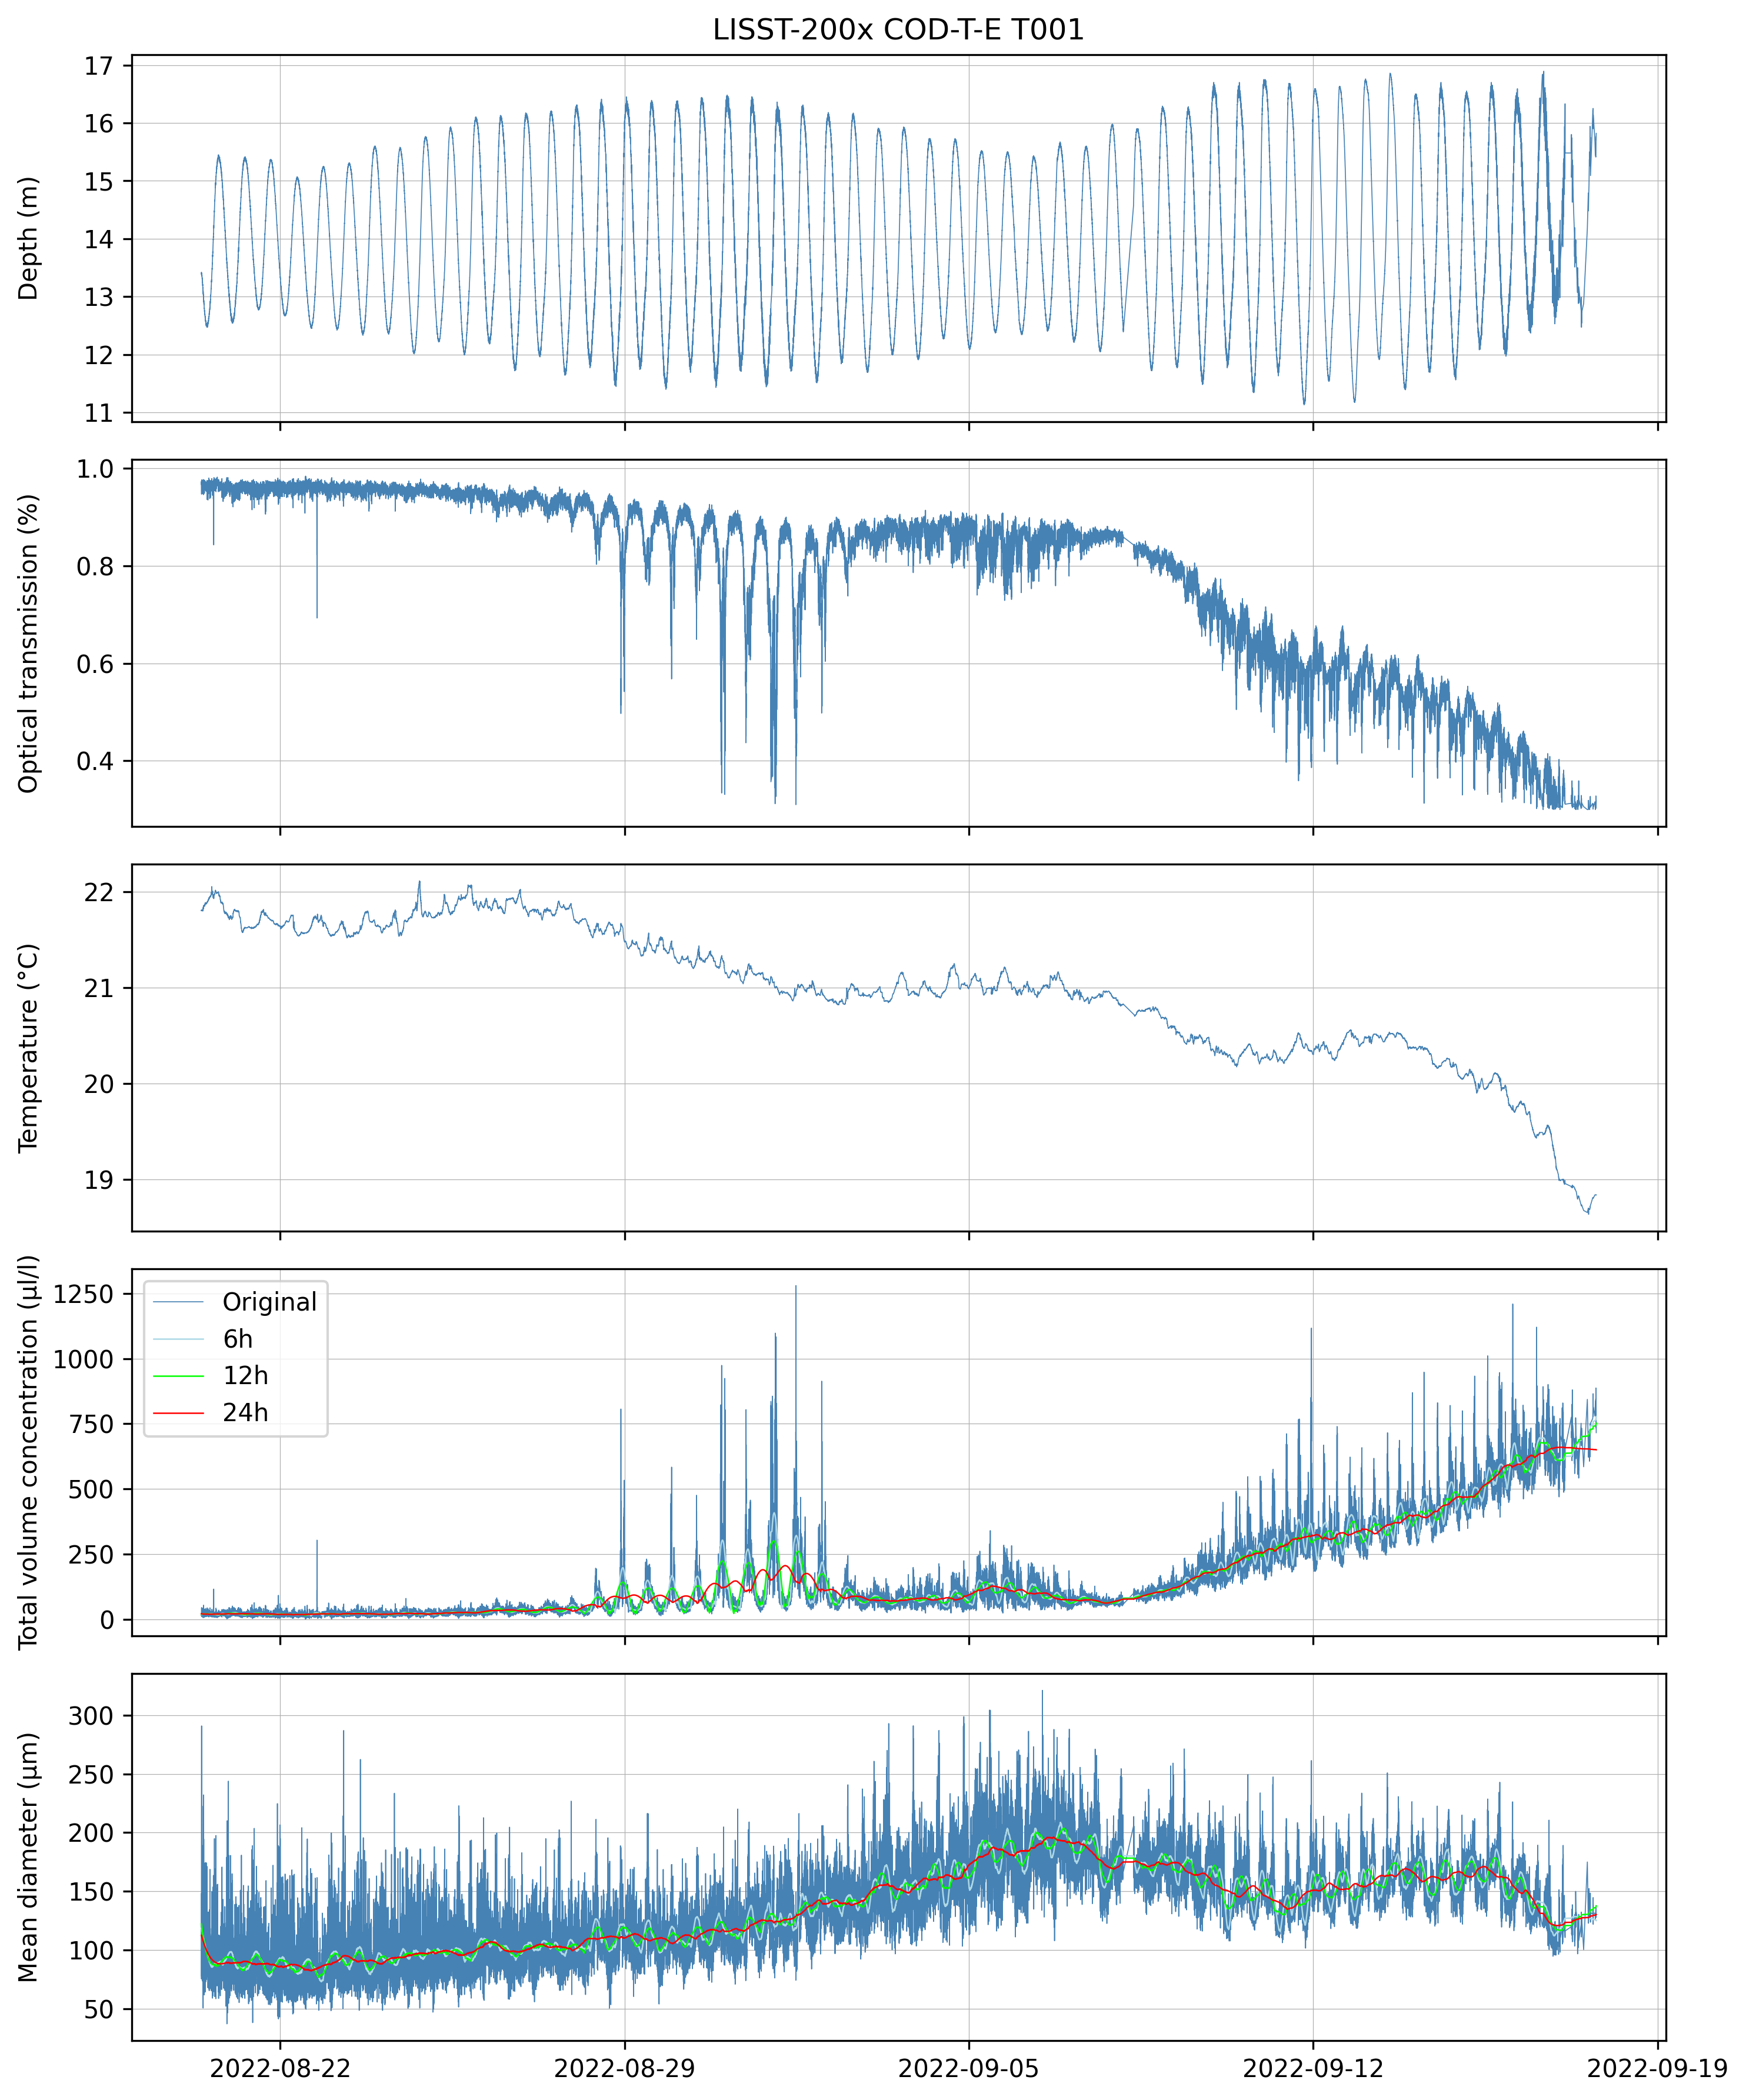

In [24]:
                                                    ## Cell 07 ##
try:
    threshold = int(input("Enter the threshold for flag filtration (default is 4): ") or 4)
except ValueError:
    print("Invalid input, defaulting to threshold = 4.")
    threshold = 4

outliers = input("Remove outliers (yes or no): ")

# Apply initial filters
filtered_data = data[
    (data['total_volume_concentration_ppm'] != 0) & 
    (data['mean_diameter_um'].notna()) & 
    (data['flag'] < threshold)
]

# Additional filtering based on outliers
if outliers.lower() == 'yes':
    filtered_data = filtered_data[filtered_data['is_outlier'] != True]
elif outliers.lower() != 'no':
    print("Invalid input for outliers; no outlier filtering applied.")

# Display the filtered data
print(f"After filtering, the dataset is:")
display(filtered_data)

# Save filtered data as csv
filtered_data_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-clean-data.csv"
filtered_data.to_csv(filtered_data_path, index=False)
print(f"Filtered data saved to {filtered_data_path}")

# Apply Savitzky-Golay filter
filtered_data['mean_diameter_filtered_6h'] = savgol_filter(filtered_data['mean_diameter_um'], 359, 3)
filtered_data['mean_diameter_filtered_12h'] = savgol_filter(filtered_data['mean_diameter_um'], 719, 3)
filtered_data['mean_diameter_filtered_24h'] = savgol_filter(filtered_data['mean_diameter_um'], 1439, 3)
filtered_data['total_volume_filtered_6h'] = savgol_filter(filtered_data['total_volume_concentration_ppm'], 359, 3)
filtered_data['total_volume_filtered_12h'] = savgol_filter(filtered_data['total_volume_concentration_ppm'], 719, 3)
filtered_data['total_volume_filtered_24h'] = savgol_filter(filtered_data['total_volume_concentration_ppm'], 1439, 3)

# New graph with clean and filtered data
fig, axs = plt.subplots(5, 1, figsize=(10, 12), dpi=300, sharex=True)
axs[0].set_title(f'LISST-200x {location} {deployment_code}')
axs[0].plot(filtered_data['datetime'], filtered_data['depth_in_m'], color='steelblue', linestyle='-', linewidth=0.4)
axs[0].set_ylabel('Depth (m)')
axs[0].grid(axis='both', which='both', linewidth=0.3)
axs[1].plot(filtered_data['datetime'], filtered_data['computed_optical_transmission'], color='steelblue', linestyle='-', linewidth=0.4)
axs[1].set_ylabel('Optical transmission (%)')
axs[1].grid(axis='both', which='both', linewidth=0.3)
axs[2].plot(filtered_data['datetime'], filtered_data['temperature_C'], color='steelblue', linestyle='-', linewidth=0.4)
axs[2].set_ylabel('Temperature (°C)')
axs[2].grid(axis='both', which='both', linewidth=0.3)
axs[3].plot(filtered_data['datetime'], filtered_data['total_volume_concentration_ppm'], color='steelblue', linestyle='-', linewidth=0.4, label='Original')
axs[3].plot(filtered_data['datetime'], filtered_data['total_volume_filtered_6h'], color='lightblue', linestyle='-', linewidth=0.6, label='6h')
axs[3].plot(filtered_data['datetime'], filtered_data['total_volume_filtered_12h'], color='lime', linestyle='-', linewidth=0.6, label='12h')
axs[3].plot(filtered_data['datetime'], filtered_data['total_volume_filtered_24h'], color='red', linestyle='-', linewidth=0.6, label='24h')
axs[3].set_ylabel('Total volume concentration (µl/l)')
axs[3].grid(axis='both', which='both', linewidth=0.3)
axs[3].legend()
axs[4].plot(filtered_data['datetime'], filtered_data['mean_diameter_um'], color='steelblue', linestyle='-', linewidth=0.4, label='Original')
axs[4].plot(filtered_data['datetime'], filtered_data['mean_diameter_filtered_6h'], color='lightblue', linestyle='-', linewidth=0.6, label='6h')
axs[4].plot(filtered_data['datetime'], filtered_data['mean_diameter_filtered_12h'], color='lime', linestyle='-', linewidth=0.6, label='12h')
axs[4].plot(filtered_data['datetime'], filtered_data['mean_diameter_filtered_24h'], color='red', linestyle='-', linewidth=0.6, label='24h')
axs[4].set_ylabel('Mean diameter (µm)')
axs[4].grid(axis='both', which='both', linewidth=0.3)
axs[4].set_xlabel('')
axs[4].xaxis.set_major_locator(mdates.DayLocator(interval=7))
fig.align_ylabels()
plt.tight_layout()
plt.show()

graph_file_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-g-filtered-graph2.png"
fig.savefig(graph_file_path)
                                                        ###

#### Stage 3 - Step 4: Computation of the full PSD and evolution of the PSD with tides

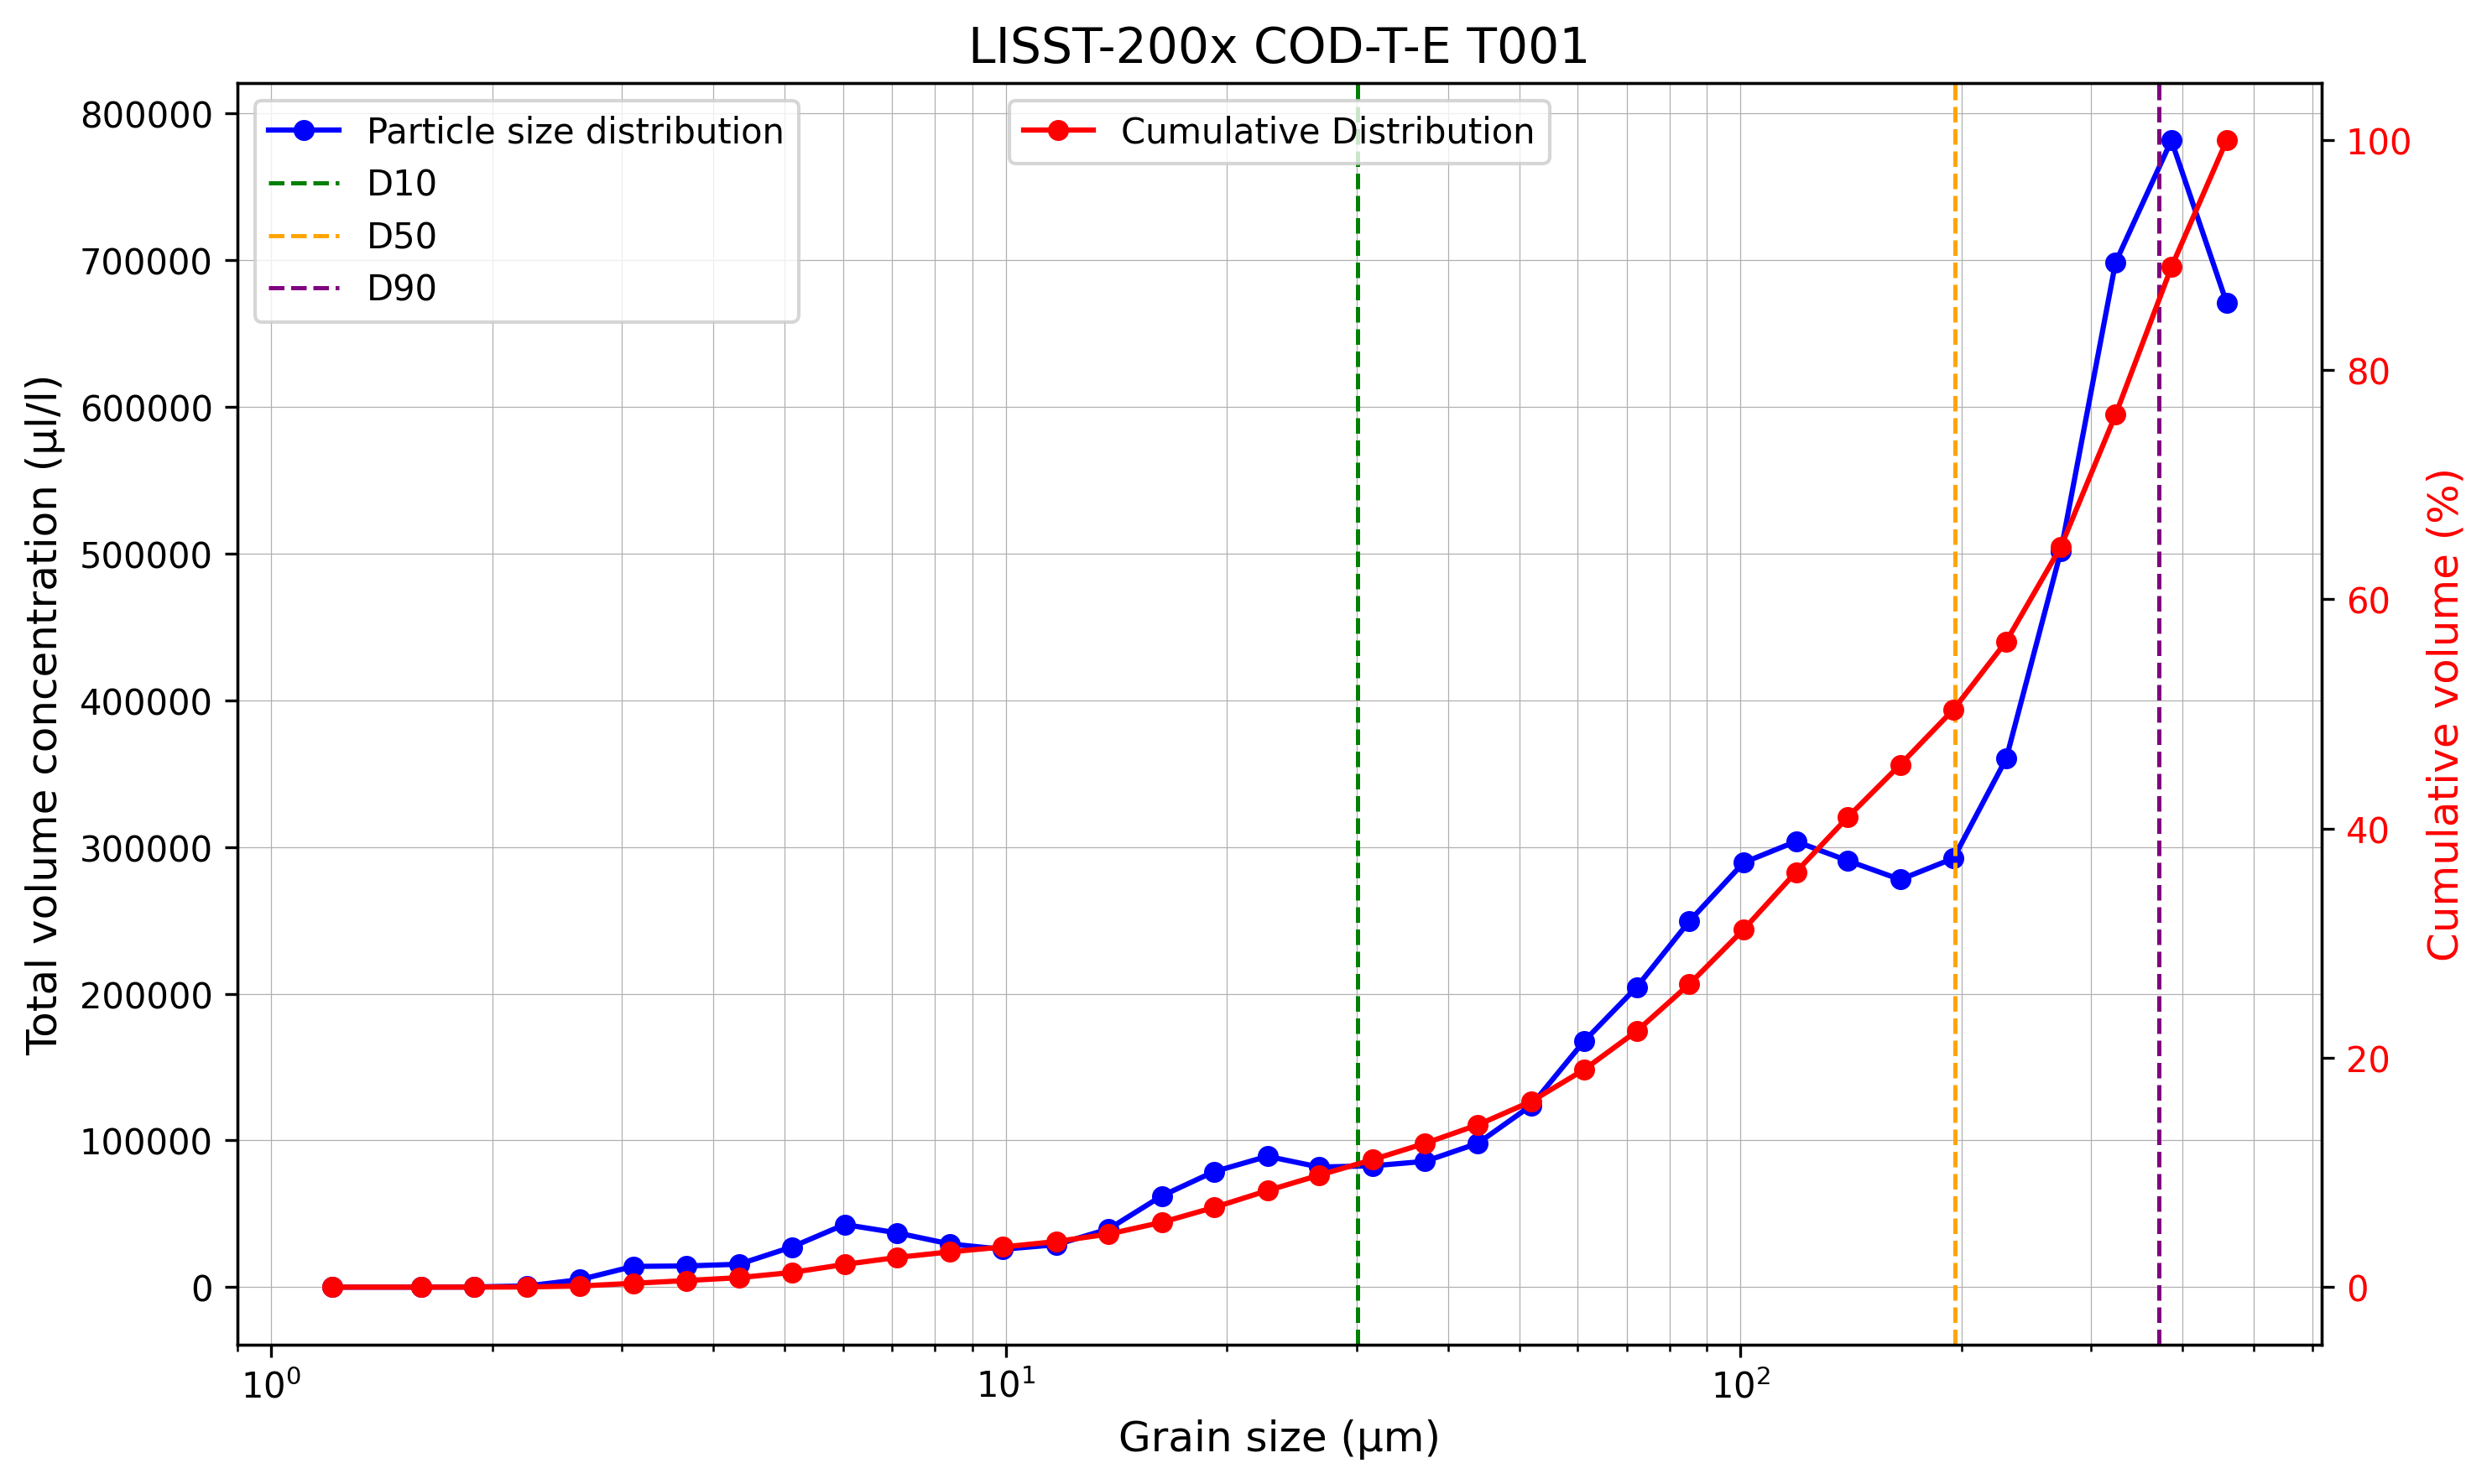

Graph saved to C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed/T001-COD-T-E-LISST200x-full-PSD.png
Summary table saved to: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed/T001-COD-T-E-LISST200x-tide-summary.csv


,expected_tide,mean_total_volume_concentration,mean_diameter,mean_D10,mean_D50,mean_D90,mean_span,mean_std_dev,mean_mode
0,High Tide,150.672532,137.258275,30.604878,202.553749,376.027100,1.846694,142.406446,301.729178
1,Low Tide,137.264398,129.118923,26.630269,187.780130,365.517177,1.887009,140.242743,292.585144
2,Other,155.595776,134.581744,29.996269,195.601736,370.672147,1.863871,140.648770,296.362351
3,Slack Tide,168.573506,140.755624,32.882828,204.463143,374.077422,1.785859,140.379678,298.850023


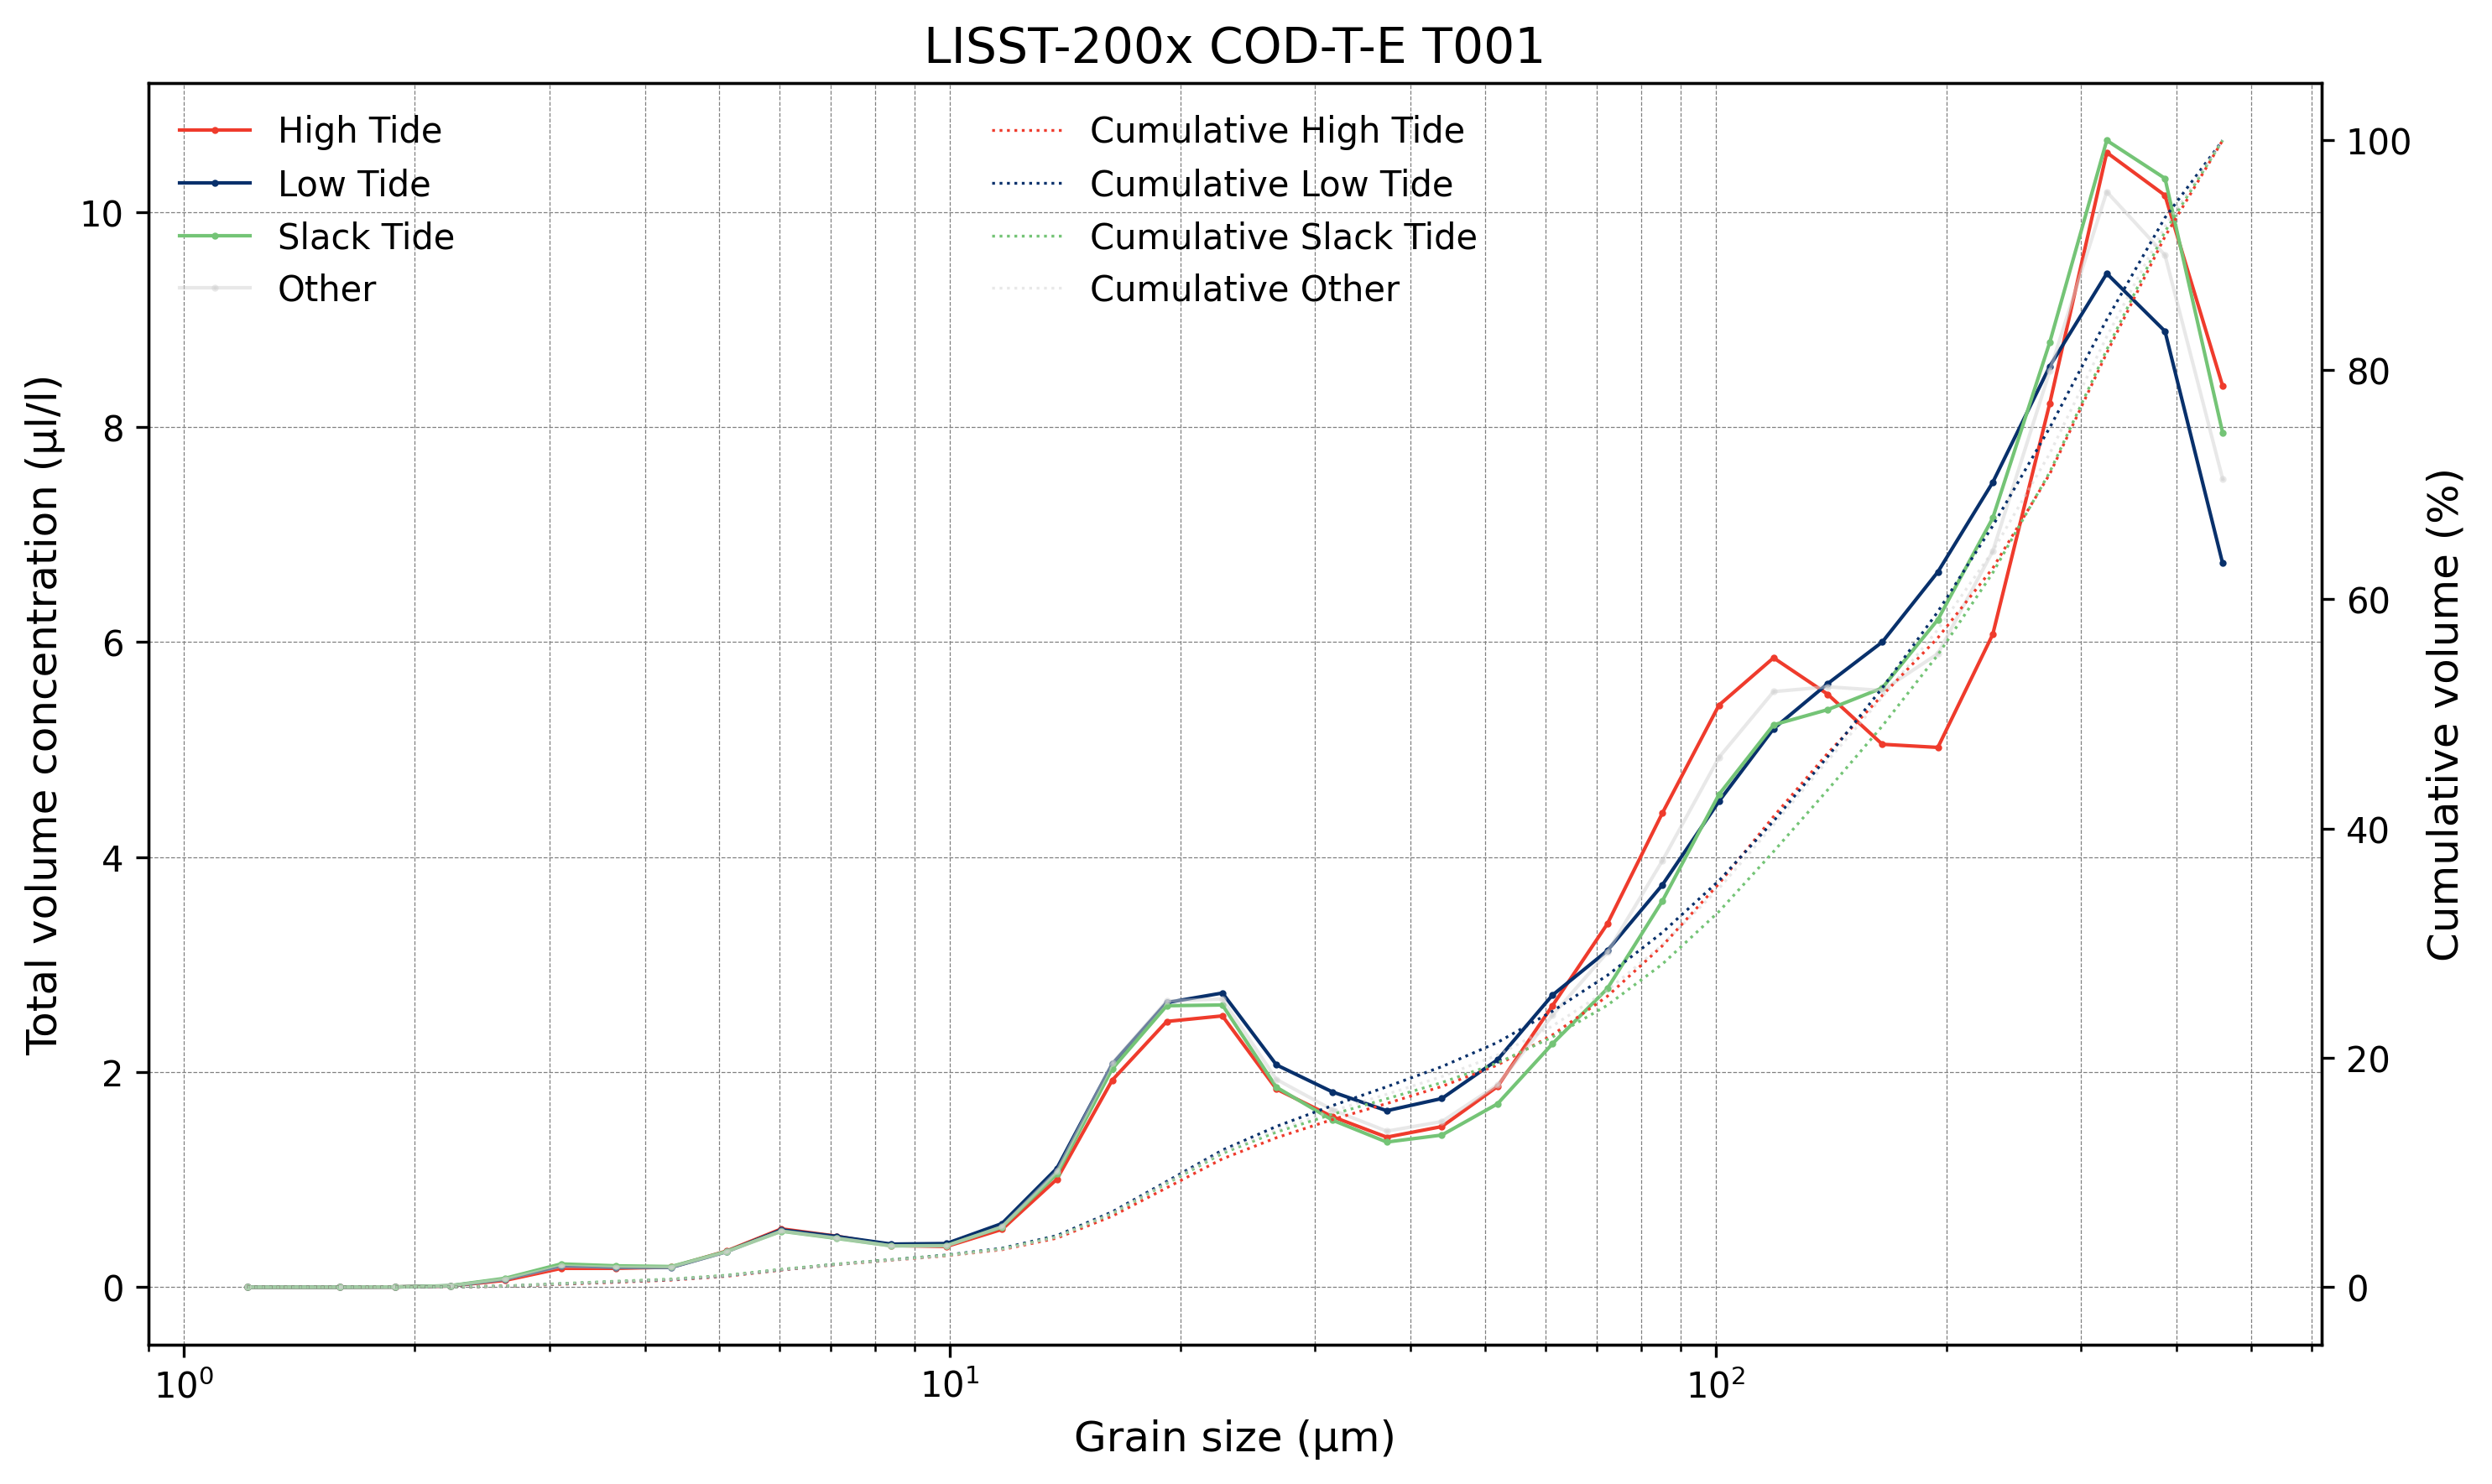

Graph saved to C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Tripod_COD_001_LISST200x/LISST-200x-T001-COD-T-E-processed/T001-COD-T-E-LISST200x-PSD-tidal-conditions.png


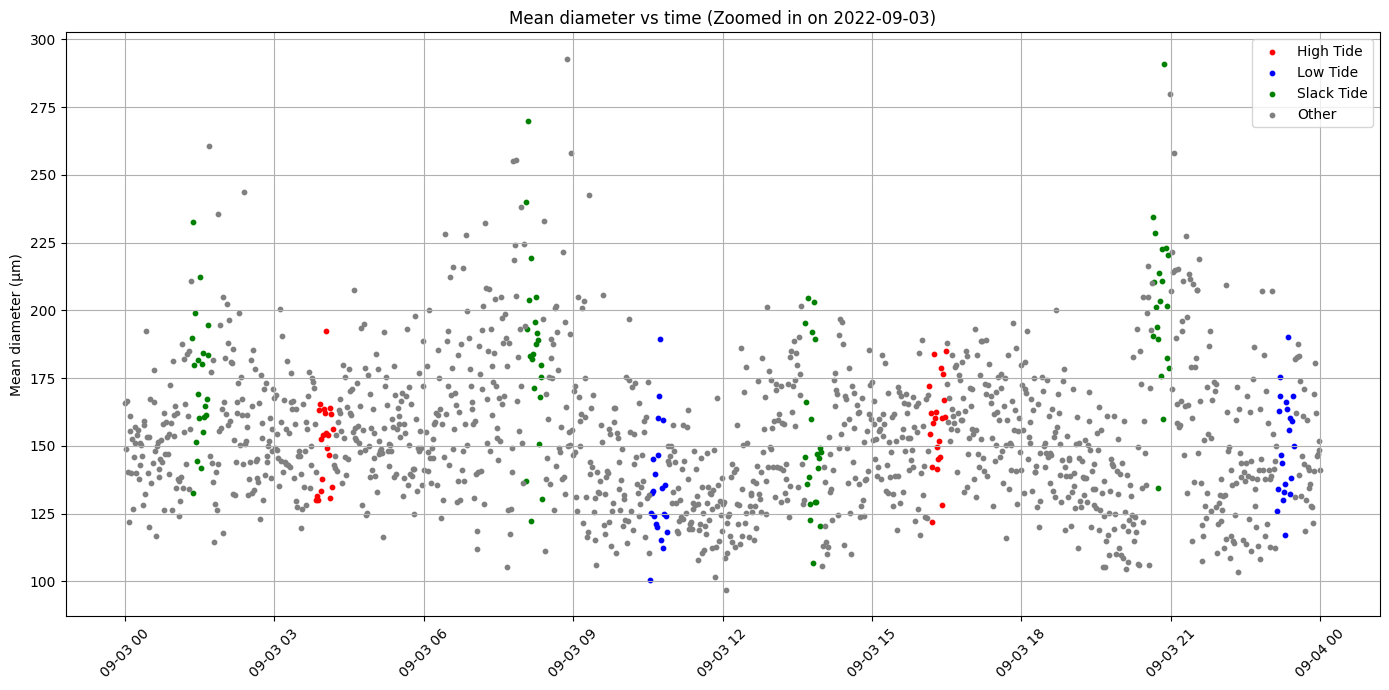

In [25]:
                                                    ## Cell 08 ##
# Total volume concentration per class (for full PSD)
volume_concentration_columns = ["1.21","1.6","1.89","2.23","2.63","3.11","3.67","4.33","5.11","6.03","7.11","8.39","9.90","11.7","13.8","16.3","19.2","22.7","26.7","31.6","37.2","43.9","51.9","61.2","72.2","85.2","101","119","140","165","195","230","273","324","386","459"]
total_volume_concentration_per_class = filtered_data[volume_concentration_columns].sum(axis=0)
average_volume_fractions = filtered_data[volume_concentration_columns].mean()
volume_concentrations = filtered_data[volume_concentration_columns].values
grain_sizes = np.array([float(col) for col in volume_concentration_columns])

# Create figure and axis for full PSD plot
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)

# Plot the full Particle Size Distribution (PSD) on a logarithmic scale
ax1.plot(grain_sizes, total_volume_concentration_per_class, color='blue', marker='o', 
         label='Particle size distribution', linestyle='-', markersize=5)
ax1.set_xscale('log')
ax1.set_xlabel('Grain size (µm)', fontsize=12)
ax1.set_ylabel('Total volume concentration (µl/l)', fontsize=12)
ax1.set_title(f'LISST-200x {location} {deployment_code}', fontsize=14)
ax1.grid(axis='both', which='both', linewidth=0.3)

# Calculate cumulative volume distribution
cumulative_volumes = np.cumsum(total_volume_concentration_per_class)

# Create secondary axis for the Cumulative Volume Distribution
ax2 = ax1.twinx()
ax2.plot(grain_sizes, cumulative_volumes / cumulative_volumes[-1] * 100, color='red', 
         label='Cumulative Distribution', marker='o', linestyle='-', markersize=5)
ax2.set_ylabel('Cumulative volume (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add lines for D10, D50, D90 values
ax1.axvline(filtered_data['D10_um'].mean(), color='green', linestyle='--', label='D10', linewidth=1.2)
ax1.axvline(filtered_data['D50_um'].mean(), color='orange', linestyle='--', label='D50', linewidth=1.2)
ax1.axvline(filtered_data['D90_um'].mean(), color='purple', linestyle='--', label='D90', linewidth=1.2)

# Add legends for the two y-axes
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper center', fontsize=10)

# Tight layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()

# Save the graph as PNG
graph_file_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-full-PSD.png"
fig.savefig(graph_file_path)
print(f"Graph saved to {graph_file_path}")

### Plot PSD for High and Low Tide Conditions

def classify_tides_with_12h_window(data):
    # Ensure data is sorted by datetime
    data = data.sort_values(by='datetime').reset_index(drop=True)
    
    # Smooth the depth data with Savitzky-Golay filter
    sampling_interval = (data['datetime'].iloc[1] - data['datetime'].iloc[0]).total_seconds() / 3600  # In hours
    time_interval = timedelta(hours=3)
    window_size = int(time_interval.total_seconds() / (sampling_interval * 3600))  # Approx. 3-hour window
    if window_size % 2 == 0:  # Ensure window size is odd
        window_size += 1
    
    data['smoothed_depth'] = savgol_filter(data['depth_in_m'], window_length=window_size, polyorder=3)
    
    # Apply a 12-hour rolling window to identify high tides (maxima) and low tides (minima)
    rolling_window = int(timedelta(hours=12).total_seconds() / (sampling_interval * 3600))
    if rolling_window % 2 == 0:  # Ensure rolling window size is odd
        rolling_window += 1

    data['rolling_max'] = data['smoothed_depth'].rolling(window=rolling_window, center=True).max()
    data['rolling_min'] = data['smoothed_depth'].rolling(window=rolling_window, center=True).min()
    
    # Identify high and low tides
    data['is_high_tide'] = data['smoothed_depth'] == data['rolling_max']
    data['is_low_tide'] = data['smoothed_depth'] == data['rolling_min']
    
    # Extract high tide and low tide information
    high_tides = data[data['is_high_tide']][['datetime', 'smoothed_depth']].rename(columns={'smoothed_depth': 'high_tide_depth'})
    low_tides = data[data['is_low_tide']][['datetime', 'smoothed_depth']].rename(columns={'smoothed_depth': 'low_tide_depth'})
    
    # Reset index for convenience
    high_tides = high_tides.reset_index(drop=True)
    low_tides = low_tides.reset_index(drop=True)
    
    # Combine high and low tides into one DataFrame
    tides = pd.concat([high_tides, low_tides], keys=['high', 'low']).sort_values(by='datetime')
    
    # Define slack tide offset and buffer
    slack_offset = timedelta(hours=2, minutes=30)
    buffer = timedelta(minutes=10)
    
    slack_tides = []
    ebb_tides = []
    flow_tides = []
    
    # Generate slack tide times and classify ebb and flow
    for i, row in tides.iterrows():
        if 'high_tide_depth' in row:  # High tide
            high_tide = row['datetime']
            slack_tide = high_tide - slack_offset
            slack_tides.append(slack_tide)
            ebb_tides.append((high_tide, slack_tide))
        elif 'low_tide_depth' in row:  # Low tide
            low_tide = row['datetime']
            slack_tide = low_tide - slack_offset
            slack_tides.append(slack_tide)
            flow_tides.append((low_tide, slack_tide))
    
    # Classify tides for each timestamp in the dataset
    def classify_timestamp(timestamp):
        for high in high_tides['datetime']:
            if high - buffer <= timestamp <= high + buffer:
                return "High Tide"
        for low in low_tides['datetime']:
            if low - buffer <= timestamp <= low + buffer:
                return "Low Tide"
        for slack in slack_tides:
            if slack - buffer <= timestamp <= slack + buffer:
                return "Slack Tide"
        return "Other"
    
    # Apply classification to dataset
    data['expected_tide'] = data['datetime'].apply(classify_timestamp)
    
    return data

# Assuming `filtered_data` contains datetime and depth_in_m columns
filtered_data = classify_tides_with_12h_window(filtered_data)

def summarize_tides_data(filtered_data, output_directory, campaign_code, location):
    # Create a summary table grouped by 'expected_tide' column
    summary_table = filtered_data.groupby('expected_tide').agg(
        mean_total_volume_concentration=('total_volume_concentration_ppm', 'mean'),
        mean_diameter=('mean_diameter_um', 'mean'),
        mean_D10=('D10_um', 'mean'),
        mean_D50=('D50_um', 'mean'),
        mean_D90=('D90_um', 'mean'),
        mean_span=('span', 'mean'),
        mean_std_dev=('std_dev_um', 'mean'),
        mean_mode=('mode_um', 'mean')  # Handle volume columns
    ).reset_index()

    # Save the summary table to CSV
    summary_table_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-tide-summary.csv"
    summary_table.to_csv(summary_table_path, index=False)
    
    print(f"Summary table saved to: {summary_table_path}")
    return summary_table

# Generate the summary table
summary_table = summarize_tides_data(filtered_data, output_directory, deployment_code, location)
display(summary_table)

# Generate the plot
volume_concentration_columns = ["1.21_%", "1.6_%", "1.89_%", "2.23_%", "2.63_%", "3.11_%", "3.67_%", "4.33_%", "5.11_%", "6.03_%", "7.11_%", "8.39_%", "9.90_%", 
                                "11.7_%", "13.8_%", "16.3_%", "19.2_%", "22.7_%", "26.7_%", "31.6_%", "37.2_%", "43.9_%", "51.9_%", "61.2_%", 
                                "72.2_%", "85.2_%", "101_%", "119_%", "140_%", "165_%", "195_%", "230_%", "273_%", "324_%", "386_%", "459_%"]

# Subset data based on tide types
high_tide_data = filtered_data[filtered_data['expected_tide'] == 'High Tide']
low_tide_data = filtered_data[filtered_data['expected_tide'] == 'Low Tide']
slack_tide_data = filtered_data[filtered_data['expected_tide'] == 'Slack Tide']
other_data = filtered_data[filtered_data['expected_tide'] == 'Other']

# Calculate total volume concentration for each tide type
high_tide_concentration = high_tide_data[volume_concentration_columns].mean(axis=0)
low_tide_concentration = low_tide_data[volume_concentration_columns].mean(axis=0)
slack_tide_concentration = slack_tide_data[volume_concentration_columns].mean(axis=0)
other_concentration = other_data[volume_concentration_columns].mean(axis=0)

colors = {
    'High Tide': '#ef3b2c',   # Red
    'Low Tide': '#08306b',  # Dark Blue
    'Slack Tide': '#74c476', # Green
    'Other': 'lightgrey', # Grey
}

# Define line styles and alpha for prominence
line_styles = {
    'High Tide': {'linestyle': '-', 'alpha': 1.0},
    'Low Tide': {'linestyle': '-', 'alpha': 1.0},
    'Slack Tide': {'linestyle': '-', 'alpha': 1.0},
    'Other': {'linestyle': '-', 'alpha': 0.5}
}

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)

# Plot the total volume concentration for each tide type
for tide, concentration, label in zip(
    ['High Tide', 'Low Tide', 'Slack Tide', 'Other'],
    [high_tide_concentration, low_tide_concentration, slack_tide_concentration, other_concentration],
    ['High Tide', 'Low Tide', 'Slack Tide', 'Other']
):
    ax1.plot(
        grain_sizes, 
        concentration, 
        color=colors[label], 
        label=label, 
        marker='o', 
        markersize=1, 
        linewidth=1.0, 
        **line_styles[label]
    )

# Set log scale for x-axis and labels for axes
ax1.set_xscale('log')
ax1.set_xlabel('Grain size (µm)', fontsize=12)
ax1.set_ylabel('Total volume concentration (µl/l)', fontsize=12)
ax1.set_title(f'LISST-200x {location} {deployment_code}', fontsize=14)
ax1.grid(axis='both', which='both', linewidth=0.3, linestyle='--', color='gray')

# Calculate cumulative volume distribution for each tide type
cumulative_volumes = {
    'High Tide': np.cumsum(high_tide_concentration),
    'Low Tide': np.cumsum(low_tide_concentration),
    'Slack Tide': np.cumsum(slack_tide_concentration),
    'Other': np.cumsum(other_concentration)
}

# Create secondary axis for the Cumulative Volume Distribution
ax2 = ax1.twinx()
for tide, cumulative_volume in cumulative_volumes.items():
    ax2.plot(
        grain_sizes, 
        cumulative_volume / cumulative_volume[-1] * 100, 
        color=colors[tide], 
        linestyle=':', 
        linewidth=0.8, 
        alpha=line_styles[tide]['alpha'], 
        label=f'Cumulative {tide}'
    )

# Set y-axis label for cumulative volume
ax2.set_ylabel('Cumulative volume (%)', color='k', fontsize=12)
ax2.tick_params(axis='y', labelcolor='k')

# Add legends for the two y-axes
ax1.legend(loc='upper left', fontsize=10, frameon=False)
ax2.legend(loc='upper center', fontsize=10, frameon=False)

# Tight layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()

# Save the graph
graph_file_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-PSD-tidal-conditions.png"
fig.savefig(graph_file_path, bbox_inches='tight')
print(f"Graph saved to {graph_file_path}")

import random

def plot_tide_classified_data(filtered_data):
    # Define colors for each tide type
    tide_colors = {
        "High Tide": "red",
        "Low Tide": "blue",
        "Slack Tide": "green",
        "Other": "grey"
    }
    
    # Randomly select a day from the deployment
    random_day = random.choice(pd.to_datetime(filtered_data['datetime']).dt.date.unique())
    zoomed_data = filtered_data[filtered_data['datetime'].dt.date == random_day]

    # Plotting the zoomed data for the random day
    plt.figure(figsize=(14, 7))
    for tide_type, color in tide_colors.items():
        # Filter data for each tide type
        tide_data = zoomed_data[zoomed_data['expected_tide'] == tide_type]
        plt.scatter(tide_data['datetime'], tide_data['mean_diameter_um'], 
                    color=color, label=tide_type, s=10)
    
    # Formatting the zoomed plot
    plt.title(f'Mean diameter vs time (Zoomed in on {random_day})')
    plt.xlabel('')
    plt.ylabel('Mean diameter (µm)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
plot_tide_classified_data(filtered_data)
                                                        ###